In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
from scipy.spatial import Delaunay
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import collections
from collections import defaultdict
from Geometry3D import *
import copy
import random
import itertools
from scipy.stats import truncnorm
from scipy.stats import bernoulli
import math
import shapely
from shapely.geometry import Point as pointpoint
from shapely.geometry.polygon import Polygon as polygonpolygon
from shapely.geometry import MultiPolygon
from itertools import permutations
import shapely.geometry as sg
import pandas as pd
import time
import json
epsilon = 10e-7
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# Helpful functions

In [2]:
#Binary function that 
#- returns "True" if edges are parallel or coincide
#- returns "False" if not

# a = [7/3, 1, 2, 0, 0, 1]
# b = [2, 0, 0, 1, 0, 2]

def parallelism(a, b):
    
    if np.abs((a[0] - a[2])*(b[1] - b[3]) - (a[1] - a[3])*(b[0] - b[2])) < epsilon:
        
        return True
    
    else:
        
        return False

In [3]:
#Intersection point of two edges or their continuations

#a = [3, 3, 0, 1, 0, 1]
#b = [2, 1, 1, 1, 0, 2]

def edges_intersection(a, b):
    
    return [((a[0]*a[3] - a[1]*a[2])*(b[0] - b[2])-(a[0] - a[2])*(b[0]*b[3] - b[1]*b[2]))/ \
            ((a[0] - a[2])*(b[1] - b[3])-(a[1]-a[3])*(b[0] - b[2])), \
            (((a[0]*a[3] - a[1]*a[2])*(b[1] - b[3])-(a[1] - a[3])*(b[0]*b[3] - b[1]*b[2]))/ \
            ((a[0] - a[2])*(b[1] - b[3])-(a[1]-a[3])*(b[0] - b[2])))]

In [4]:
#Binary function that
#- returns "True" if edges a and b are not parallel and intersect in the interior of any of edges
#- returns "False" if edges are parallel or don't intersection or it's intersection - common vertex 

# a = [4, 2, 5, 3, 3, 0] 
# b = [2.3476259661391095, 1.026174593643856, 5, 3, 3, 6]

def intersection_inmid(a, b):

    if parallelism(a, b) == True:
        
        return False
    
    else:
        
        #p - intersection of edges'cintinuations
        p = edges_intersection(a, b)

        if (((p[0] - a[0] > epsilon) and (a[2] - p[0] > epsilon)) or ((a[0] - p[0] > epsilon) and (p[0] - a[2] > epsilon)) or\
            ((np.abs(p[0] - a[0]) < epsilon) and (np.abs(p[0] - a[2]) < epsilon))) and\
    (((p[0] - b[0] > epsilon) and (b[2] - p[0] > epsilon)) or ((b[0] - p[0] > epsilon) and (p[0] - b[2] > epsilon)) or\
     ((np.abs(p[0] - b[0]) < epsilon) and (np.abs(p[0] - b[2]) < epsilon))) and\
    (((p[1] - a[1] > epsilon) and (a[3] - p[1] > epsilon)) or ((a[1] - p[1] > epsilon) and (p[1] - a[3] > epsilon)) or\
     ((np.abs(p[1] - a[1]) < epsilon) and (np.abs(p[1] - a[3]) < epsilon))) and\
    (((p[1] - b[1] > epsilon) and (b[3] - p[1] > epsilon)) or ((b[1] - p[1] > epsilon) and (p[1] - b[3] > epsilon)) or\
     ((np.abs(p[1] - b[1]) < epsilon) and (np.abs(p[1] - b[3]) < epsilon))):
            
            return True
        
        else:
            
            return False

In [5]:
#Number of unique levels including 0

def nlevels(poly):
    return len(np.unique([i[3] for i in poly]))

In [6]:
#Number of non-zero spaces in poly

def nspaces(poly):
    
    #list_spaces: [1 2 3]
    list_spaces = np.unique([i[4] for i in poly])

    if 0 in list_spaces:
        nspaces = len(list_spaces) - 1
    else:
        nspaces = len(list_spaces)
    
    return nspaces

In [7]:
def v(poly):
    v = defaultdict(list)
    for i in range(nlevels(poly)):
        for j in poly:
            if j[3] == i:
                if [x for y in [j[0], [i], [j[4]]] for x in y] not in v[i]:
                    v[i].append([x for y in [j[0], [i], [j[4]]] for x in y])
                if [x for y in [j[1], [i], [j[4]]] for x in y] not in v[i]:
                    v[i].append([x for y in [j[1], [i], [j[4]]] for x in y])
                if [x for y in [j[2], [i], [j[4]]] for x in y] not in v[i]:
                    v[i].append([x for y in [j[2], [i], [j[4]]] for x in y])
    return v

In [8]:
#unique vertices on the level

def unique_v(poly):
    v = defaultdict(list)
    for i in range(nlevels(poly)):
        for j in poly:
            if j[3] == i:
                if [x for y in [j[0], [i]] for x in y] not in v[i]:
                    v[i].append([x for y in [j[0], [i]] for x in y])
                if [x for y in [j[1], [i]] for x in y] not in v[i]:
                    v[i].append([x for y in [j[1], [i]] for x in y])
                if [x for y in [j[2], [i]] for x in y] not in v[i]:
                    v[i].append([x for y in [j[2], [i]] for x in y])
    return v

In [9]:
def e(poly):
    e = defaultdict(list)
    for i in range(nlevels(poly)):
        for j in poly:
            if j[3] == i:
                if ([j[0], j[1], i, j[4]] not in e[i]) and ([j[1], j[0], i, j[4]] not in e[i]):
                    e[i].append([x for y in [j[0], j[1], [i], [j[4]]] for x in y])
                if ([j[1], j[2], i, j[4]] not in e[i]) and ([j[2], j[1], i, j[4]] not in e[i]):
                    e[i].append([x for y in [j[1], j[2], [i], [j[4]]] for x in y])
                if ([j[0], j[2], i, j[4]] not in e[i]) and ([j[2], j[0], i, j[4]] not in e[i]):
                    e[i].append([x for y in [j[0], j[2], [i], [j[4]]] for x in y])
    return e

In [10]:
#unique edges on the level

def unique_e(poly):
    
    e = defaultdict(list)
    
    #i - level including zero and maximal level
    for i in range(nlevels(poly)):
        
        #j - cell on level i
        for j in poly:
            if j[3] == i:
                
                #To key i we add value [0, 0, 2, 0, level] if it's not already in e
                if ([x for y in [j[0], j[1], [i]] for x in y] not in e[i]) and ([x for y in [j[1], j[0], [i]] for x in y] not in e[i]):
                    e[i].append([x for y in [j[0], j[1], [i]] for x in y])
                if ([x for y in [j[1], j[2], [i]] for x in y] not in e[i]) and ([x for y in [j[2], j[1], [i]] for x in y] not in e[i]):
                    e[i].append([x for y in [j[1], j[2], [i]] for x in y])
                if ([x for y in [j[0], j[2], [i]] for x in y] not in e[i]) and ([x for y in [j[2], j[0], [i]] for x in y] not in e[i]):
                    e[i].append([x for y in [j[0], j[2], [i]] for x in y])
    return e

In [11]:
def spaces_cells(poly):
    s = defaultdict(list)
    for i in range(nspaces(poly)+1):
        for j in poly:
            if j[4] == i:
                s[i].append(j)
    return s

In [12]:
def spaces_edges(poly):
    
    #s - return of the function:  space 3: edges [[0, 0, 1, 0, 1, 3], ...]
    s = defaultdict(list)
    
    #i goes through all occuring space numbers
    for i in np.unique([u[4] for u in poly]):

        #j - cells related to space i
        for j in poly:
            if j[4] == i:
                
                s[i].append([x for y in [j[0], j[1], [j[3]], [i]] for x in y])
                s[i].append([x for y in [j[1], j[2], [j[3]], [i]] for x in y])
                s[i].append([x for y in [j[0], j[2], [j[3]], [i]] for x in y])
        
    return s

In [13]:
def ext_edges_spaces(poly):
    
    #s - space 3: edges [[0, 0, 1, 0, 1, 3], ...]
    s = spaces_edges(poly)
    
    #k - space number
    for k in s:
            
        #List of indices - internal edges of space k, i.e. edges which occur more than once 
        r = []
            
        #i, j  - two different edges in space k
        for i in range(len(s[k])):
            for j in range(len(s[k])):
                if i<j:

                    #If i = j or just vertices are swapped (the edge occured twice) => add i and j to "bad" indices 
                    if ((np.abs(s[k][i][0] - s[k][j][0]) < epsilon) and (np.abs(s[k][i][1] - s[k][j][1]) < epsilon) and\
                    (np.abs(s[k][i][2] - s[k][j][2]) < epsilon) and (np.abs(s[k][i][3] - s[k][j][3]) < epsilon) and\
                    (np.abs(s[k][i][4] - s[k][j][4]) < epsilon) and (np.abs(s[k][i][5] - s[k][j][5]) < epsilon)) or \
                    ((np.abs(s[k][i][0] - s[k][j][2]) < epsilon) and (np.abs(s[k][i][1] - s[k][j][3]) < epsilon) and\
                    (np.abs(s[k][i][2] - s[k][j][0]) < epsilon) and (np.abs(s[k][i][3] - s[k][j][1]) < epsilon) and\
                    (np.abs(s[k][i][4] - s[k][j][4]) < epsilon) and (np.abs(s[k][i][5] - s[k][j][5]) < epsilon)):
                        r.append(i)
                        r.append(j)
            
        #Delete all internal edges from the list
        s[k] = np.delete(s[k], r, axis = 0)
            
        #List of indices - edges which continue each other ("bad") and should be replaces with one edge 
        r = []
            
        #v, u - two not "bad" parallel external edges
        for v in range(len(s[k])):
            for u in range(len(s[k])):
                if (v < u) and (parallelism(s[k][v], s[k][u]) == True) and (u not in r) and (v not in r):
                        
                    #Four possible option for parallel edges to continue each other (one vertex must coincide)
                    if ((np.abs(s[k][u][0] - s[k][v][0]) < epsilon) and (np.abs(s[k][u][1] - s[k][v][1]) < epsilon) and
                        (np.abs(s[k][u][4] - s[k][v][4]) < epsilon) and (np.abs(s[k][u][5] - s[k][v][5]) < epsilon)) :

                        #Add good big edge
                        s[k] = np.vstack((s[k], [s[k][v][2], s[k][v][3], s[k][u][2], s[k][u][3], s[k][v][4], s[k][v][5]]))
                            
                        #Add "bad"edges to list r for removal 
                        r.append(u)
                        r.append(v)
                            
                    elif ((np.abs(s[k][u][0] - s[k][v][2]) < epsilon) and (np.abs(s[k][u][1] - s[k][v][3]) < epsilon) and\
                          (np.abs(s[k][u][4] - s[k][v][4]) < epsilon) and (np.abs(s[k][u][5] - s[k][v][5]) < epsilon)):
                            
                        s[k] = np.vstack((s[k], [s[k][v][0], s[k][v][1], s[k][u][2], s[k][u][3], s[k][v][4], s[k][v][5]]))
                        r.append(u)
                        r.append(v)
                            
                    elif ((np.abs(s[k][u][2] - s[k][v][2]) < epsilon) and (np.abs(s[k][u][3] - s[k][v][3]) < epsilon) and\
                          (np.abs(s[k][u][4] - s[k][v][4]) < epsilon) and (np.abs(s[k][u][5] - s[k][v][5]) < epsilon)):
                            
                        s[k] = np.vstack((s[k], [s[k][v][0], s[k][v][1], s[k][u][0], s[k][u][1], s[k][v][4], s[k][v][5]]))
                        r.append(u)
                        r.append(v)
                            
                    elif ((np.abs(s[k][u][2] - s[k][v][0]) < epsilon) and (np.abs(s[k][u][3] - s[k][v][1]) < epsilon) and\
                          (np.abs(s[k][u][4] - s[k][v][4]) < epsilon) and (np.abs(s[k][u][5] - s[k][v][5]) < epsilon)):
                        
                        s[k] = np.vstack((s[k], [s[k][v][2], s[k][v][3], s[k][u][0], s[k][u][1], s[k][v][4], s[k][v][5]]))
                        r.append(u)
                        r.append(v)
            
        #Delete all extra edges
        s[k] = np.delete(s[k], r, axis = 0)
        
    return s


In [14]:
def spacesbylevel(poly):
    s = defaultdict(list)
    for i in range(nlevels(poly)):
        for j in poly:
            if j[3] == i:
                s[i].append(j)
    return s

In [15]:
# Order point in clockwise order

def f(origin, refvec):
    def clockwiseangle_and_distance(point):
    
        # Vector between point and the origin: v = p - o
        vector = [point[0]-origin[0], point[1]-origin[1]]
        # Length of vector: ||v||
        lenvector = math.hypot(vector[0], vector[1])
        # If length is zero there is no angle
        if lenvector == 0:
            return -math.pi, 0
        # Normalize vector: v/||v||
        normalized = [vector[0]/lenvector, vector[1]/lenvector]
        dotprod  = normalized[0]*refvec[0] + normalized[1]*refvec[1]     # x1*x2 + y1*y2
        diffprod = refvec[1]*normalized[0] - refvec[0]*normalized[1]     # x1*y2 - y1*x2
        angle = math.atan2(diffprod, dotprod)
        # Negative angles represent counter-clockwise angles so we need to subtract them 
        # from 2*pi (360 degrees)
        if angle < 0:
            return 2*math.pi+angle, lenvector
        # I return first the angle because that's the primary sorting criterium
        # but if two vectors have the same angle then the shorter distance should come first.
        return angle, lenvector
    return clockwiseangle_and_distance

In [16]:
#Vizualization of one building design

def vis_poly(poly):
    n = 1
    colors = ['white', 'thistle', 'cornflowerblue', "skyblue", "pink", "mediumslateblue", "lightseagreen", 'plum', 'lightsteelblue', 'paleturquoise']

    for l in range(nlevels(poly)):

        plt.figure(figsize=(5,7))
        plt.subplot(int(str(nlevels(poly)) + str(1) + str(n)))

        m = 0

        #A = all cells on level l 
        A = []
        for i in poly:
            if i[3] == l:
                m+=1
                A.append(i)


        for t in range(nspaces(poly)+1):
            

            #r - list of polygons 
            r = []
            for i in range(len(A)):
                if A[i][4] == t:
                    r.append(sg.Polygon([(A[i][0][0], A[i][0][1]), (A[i][1][0], A[i][1][1]), (A[i][2][0], A[i][2][1])]))
            

            new_shape = MultiPolygon(r)
            for z in range(len(new_shape.geoms)):
#                 print(i)
                res = [list(ele) for ele in list(new_shape.geoms[z].exterior.coords[:-1])]
#                 print(l, t)
                res.append(l)
                res.append(t)
                index = 0
#                 print(res)
                for b in range(len(poly)):
                    if (np.abs(res[0][0] - poly[b][0][0]) < epsilon) and (np.abs(res[0][1] - poly[b][0][1]) < epsilon) and (np.abs(res[1][0] - poly[b][1][0]) < epsilon) and (np.abs(res[1][1] - poly[b][1][1]) < epsilon) and (np.abs(res[2][0] - poly[b][2][0]) < epsilon) and (np.abs(res[2][1] - poly[b][2][1]) < epsilon) and (np.abs(res[3] - poly[b][3]) < epsilon) and (np.abs(res[4] - poly[b][4]) < epsilon):
                        index = b
                
                xs, ys = new_shape.geoms[z].exterior.xy 
                plt.plot(xs, ys, color = 'k')
                plt.fill(xs, ys, facecolor= colors[t], edgecolor = 'black')
                plt.ylabel('Level ' + str(l))
                #with or without numbers
 #               plt.annotate(str(index), xy = [new_shape.geoms[z].centroid.x, new_shape.geoms[z].centroid.y], xytext=[new_shape.geoms[z].centroid.x, new_shape.geoms[z].centroid.y])
                
          
        plt.show()
        n += 1
    plt.show()

In [17]:
#Vizualization of the whole population (n=10)

def visualize(poly):
    f, axis = plt.subplots(4, 5)
    f.set_figwidth(30)
    f.set_figheight(15)
    
    for j in range(len(poly)):

        n = 1
        colors = ['white', 'thistle', 'cornflowerblue', "skyblue", "pink", "mediumslateblue", "lightseagreen", 'plum', 'lightsteelblue', 'paleturquoise']

        for l in range(nlevels(poly[j])):

            # plt.figure(figsize=(5,7))
            # plt.subplot(int(str(nlevels(poly)) + str(1) + str(n)))

            m = 0

            #A = all cells on level l 
            A = []
            for i in poly[j]:
                if i[3] == l:
                    m+=1
                    A.append(i)


            for t in range(nspaces(poly[j])+1):

                #r - list of polygons 
                r = []
                for i in range(len(A)):
                    if A[i][4] == t:
                        r.append(sg.Polygon([(A[i][0][0], A[i][0][1]), (A[i][1][0], A[i][1][1]), (A[i][2][0], A[i][2][1])]))


                new_shape = MultiPolygon(r)

                for geom in new_shape.geoms:    
                    xs, ys = geom.exterior.xy 
                    
                    axis[1+ 2 * (j // 5), j % 5].set_title('Design' + ' '+ str(j+1), y=-0.2)
                    if (j<(len(poly))/2):  
                          axis[l, j].plot(xs, ys, color = 'k')
                          axis[l, j].plot(xs, ys, color = 'k')
                          axis[l, j].fill(xs, ys, facecolor= colors[t], edgecolor = 'black')
                          axis[l, j].set_ylabel('Level ' + str(l))
                    else: 
                          axis[l+nlevels(poly[j]), j - 5].plot(xs, ys, color = 'k')
                          axis[l+nlevels(poly[j]), j - 5].plot(xs, ys, color = 'k')
                          axis[l+nlevels(poly[j]), j - 5].fill(xs, ys, facecolor= colors[t], edgecolor = 'black')
                          axis[l+nlevels(poly[j]), j - 5].set_ylabel('Level ' + str(l))

            n += 1
    plt.show()

In [18]:
#Polyhedron formed by space p with ordered vertices

def polyhedron(poly, p, heights):
#     print(poly, p, heights)
    ###Obtain the set of vertices of future polyhedron p
    
    #A - not unique vertices of external edges of space p [1, 2, level]
    A = []

    for a in ext_edges_spaces(poly)[p]:
        A.append([a[0], a[1], a[4]])
        A.append([a[2], a[3], a[4]])
        
    #B - unique vertices of external edges of space p [1, 2, level]
    B = np.unique(A, axis = 0)
    
    #b - list of levels in on which space p is located [1, 2, 3]
    b = []
    for k in B:
        b.append(k[2])
        
        
    #lower hight of a space
    h = 0
    for l in range(0, int(np.min(b))):
        h += heights[l]
        
    #height of the space
    s = 0
    for l in range(int(np.min(b)), int(np.max(b)+1)):
        s += heights[l]
        
    #If space p is located on one level = max(b), we create a polyhhedron with coordinates [max(b), max(b) + 1]

    if max(b) == int(np.amin(b)):
        
        points_low = [[i[0], i[1], h] for i in B] 
        points_high = [[i[0], i[1], h + heights[i[2]]] for i in B]
        
    else:
        
        points_high = [[i[0], i[1], h + s] for i in B if (i[2]==max(b))]
        points_low = [[i[0], i[1], h] for i in B if (i[2]==int(np.amin(b)))]
    
    
    s0 = 0
    s1 = 0
    for k in points_low:
        s0 += k[0]
        s1 += k[1]
    origin = [s0/len(points_low), s1/len(points_low)]
    refvec = [0, 1]
                
    key_func = f(origin, refvec)
    spoints_low = sorted(points_low, key=key_func)
        
    s0 = 0
    s1 = 0
    for k in points_high:
        s0 += k[0]
        s1 += k[1]
    origin = [s0/len(points_high), s1/len(points_high)]
    refvec = [0, 1]
                
    key_func = f(origin, refvec)
    spoints_high = sorted(points_high, key=key_func)
        
    cpg = []
    cpg.append(ConvexPolygon(tuple(Point(x) for x in spoints_high)))
    cpg.append(ConvexPolygon(tuple(Point(x) for x in spoints_low)))
        
    cpg_side = []
        
    for i in range(len(spoints_low)):
        w = [spoints_high[i % len(spoints_low)], spoints_high[(i+1) % len(spoints_low)], spoints_low[(i+1) % len(spoints_low)], spoints_low[i % len(spoints_low)]]
#         print(w)
        cpg_side.append(ConvexPolygon(tuple(Point(x) for x in w)))
        cpg.append(ConvexPolygon(tuple(Point(x) for x in w)))
            
    cph = ConvexPolyhedron(tuple(cpg))
    
    return cph


In [19]:
#Spaces intersect if they have at least one point of intersection; p, q - spaces 

def do_spaces_intersect(poly, p, q, heights):
    
    pol_p = polyhedron(poly, p, heights)
    pol_q = polyhedron(poly, q, heights)
    
    inter = intersection(pol_p, pol_q)
    return inter

In [20]:
# Create a graph of connectivity of spaces

def graph_con_spaces(poly, heights):
    
    #A = nspaces x nspaces 
    A = np.zeros([len(ext_edges_spaces(poly))-1,len(ext_edges_spaces(poly))-1], dtype=float, order='C')

    #i, j in range [1, nspaces]
    for i in range(1, nspaces(poly)+1):
        for j in range(1, nspaces(poly)+1):
            if (i<j):
                
                #If i and j intersect, then connect them in graph
                if do_spaces_intersect(poly, i, j, heights) is not None:
                    A[i-1][j-1] = 1
#     print(A)
    G = nx.from_numpy_matrix(A)
    nx.set_node_attributes(G, {0: 'thistle', 1: 'cornflowerblue', 2: "skyblue", 3: "pink"}, name="color")
    return G


In [21]:
#All colors we use

colors = ['white', 'thistle', 'cornflowerblue', "skyblue", "pink", "mediumslateblue", "lightseagreen", 'plum', 'lightsteelblue', 'paleturquoise']

In [22]:
#Visualization of a dual graph

def vis_dual(G):
    color_map = []
    a = G.number_of_nodes()
    for i in range(a):
        color_map.append(colors[i+1])
    
    nx.draw(G, node_color=color_map, with_labels=True)
    

# Generation of the sample

## Here is just one example of how the process looked like:

In [23]:
# #Generation of points inside the rectangular for the ground floor: 
# points1 = np.array([[0, 0], [0, 3], [5, 3], [5, 0], [5, 1], [4, 3], [2, 0], [1, 0]])
# tri1 = Delaunay(points1)
# tri1.simplices
# points1[tri1.simplices]
# plt.triplot(points1[:,0], points1[:,1], tri1.simplices)
# plt.plot(points1[:,0], points1[:,1], 'o')
# plt.show()

In [24]:
# points2 = np.array([[0, 0], [0, 3], [5, 3], [5, 0], [3, 2], [4, 2], [1, 1], [5, 2], [4, 0]])
# tri2 = Delaunay(points2)
# tri2.simplices
# points2[tri2.simplices]
# plt.triplot(points2[:,0], points2[:,1], tri2.simplices)
# plt.plot(points2[:,0], points2[:,1], 'o')
# plt.show()

In [25]:
# points3 = np.array([[0, 0], [0, 3], [5, 3], [5, 0], [2, 0], [0, 2], [4, 2], [4, 3], [5, 2], [4, 0]])
# tri3 = Delaunay(points3)
# tri3.simplices
# points3[tri3.simplices]
# plt.triplot(points3[:,0], points3[:,1], tri3.simplices)
# plt.plot(points3[:,0], points3[:,1], 'o')
# plt.show()

In [26]:
# points4 = np.array([[0, 0], [0, 3], [5, 3], [5, 0], [5, 1], [5, 2], [4, 0], [4, 1], [4, 2], [4, 3]])
# tri4 = Delaunay(points4)
# tri4.simplices
# points4[tri4.simplices]
# plt.triplot(points4[:,0], points4[:,1], tri4.simplices)
# plt.plot(points4[:,0], points4[:,1], 'o')
# plt.show()

In [27]:
# A = [points1[tri1.simplices], points2[tri2.simplices], points3[tri3.simplices], points4[tri4.simplices]]
# B = []
# #level
# for l in range(len(A)): 
#     #number of the cell
#     for j in range(len(A[l])):
#         B.append([x for y in [(A[l][j]).tolist(), [l], [0]] for x in y])

## Now we assign colors randomly to the cells we generated

In [28]:
# B[0][4] = 8
# B[1][4] = 0
# B[2][4] = 0
# B[3][4] = 9
# B[4][4] = 9
# B[5][4] = 9
# B[6][4] = 0
# B[7][4] = 5
# B[8][4] = 4
# B[9][4] = 5
# B[10][4] = 3
# B[11][4] = 4
# B[12][4] = 0
# B[13][4] = 0
# B[14][4] = 7
# B[15][4] = 7
# B[16][4] = 0
# B[17][4] = 0
# B[18][4] = 1
# B[19][4] = 0
# B[20][4] = 0
# B[21][4] = 6
# B[22][4] = 6
# B[23][4] = 7
# B[24][4] = 7
# B[25][4] = 0
# B[26][4] = 2
# B[27][4] = 6
# B[28][4] = 6
# B[29][4] = 0
# B[30][4] = 0
# B[31][4] = 7
# B[32][4] = 7
# B[33][4] = 7
# B[34][4] = 7

# B

## Heights were generated in the following way:

In [29]:
# heights = defaultdict()
# heights[0] = random.randint(1, 4)
# heights[1] = random.randint(1, 4)
# heights[2] = random.randint(1, 4)
# heights[3] = random.randint(1, 4)

## As the result we obtained 30 buildings

In [56]:
buildings = [[[[0, 0], [0, 3], [2, 3], 0, 9], #building[0]
  [[0, 0], [3, 3], [2, 3], 0, 9],
  [[0, 0], [3, 3], [1, 0.7], 0, 9],
  [[0, 0], [4, 2], [3, 3], 0, 0],
  [[0, 0], [4, 2], [1, 0.7], 0, 2],
  [[0, 0], [4, 0], [4, 2], 0, 2],
  [[4, 0], [5, 0], [5, 1], 0, 5],
  [[4, 0], [5, 1], [4, 2], 0, 5],
  [[5, 1], [4, 2], [5, 3], 0, 5],
  [[4, 2], [3, 3], [5, 3], 0, 0],
  [[0, 0], [0, 1], [1, 0.7], 1, 0],
  [[1, 0.7], [0, 1], [4, 2], 1, 0],
  [[0, 1], [0, 2], [4, 2], 1, 3],
  [[0, 2], [0, 3], [4, 2], 1, 3],
  [[4, 2], [0, 3], [5, 3], 1, 3],
  [[0, 0], [4, 2], [1, 0.7], 1, 2],
  [[0, 0], [3, 0], [4, 2], 1, 2],
  [[3, 0], [4, 0], [4, 2], 1, 2],
  [[4, 0], [4, 2], [5, 3], 1, 5],
  [[4, 0], [5, 0], [5, 3], 1, 5],
  [[0, 0], [1, 0.7], [0, 3], 2, 1],
  [[1, 0.7], [0, 3], [2, 3], 2, 1],
  [[0, 0], [4, 2], [1, 0.7], 2, 2],
  [[0, 0], [4, 0], [4, 2], 2, 2],
  [[4, 2], [1, 0.7], [5, 3], 2, 0],
  [[2, 3], [1, 0.7], [5, 3], 2, 0],
  [[4, 0], [5, 0], [4, 2], 2, 6],
  [[4, 2], [5, 3], [5, 0], 2, 6],
  [[0, 0], [0, 1], [2, 0], 3, 8],
  [[0, 1], [2, 0], [2, 1], 3, 8],
  [[0, 1], [2, 1], [2, 3], 3, 7],
  [[0, 1], [0, 3], [2, 3], 3, 7],
  [[2, 0], [2, 1], [5, 3], 3, 4],
  [[2, 1], [5, 3], [2, 3], 3, 0],
  [[2, 0], [5, 0], [5, 3], 3, 4]],
 [[[0, 1], [3, 3], [0, 3], 0, 9], #building[1]
  [[2, 1], [5, 3], [4, 0], 0, 2],
  [[4, 0], [5, 0], [5, 3], 0, 2],
  [[2, 1], [3, 3], [5, 3], 0, 1],
  [[2, 1], [3, 3], [1, 1], 0, 1],
  [[0, 1], [1, 1], [3, 3], 0, 9],
  [[0, 0], [0, 1], [2, 1], 0, 0],
  [[0, 0], [2, 1], [2, 0], 0, 0], 
  [[2, 0], [4, 0], [2, 1], 0, 0],
  [[0, 0], [0, 3], [1, 3], 1, 3],
  [[1, 0], [0, 0], [1, 3], 1, 3],
  [[1, 0], [1, 3], [2, 3], 1, 3],
  [[1, 0], [2, 0], [2, 3], 1, 4],
  [[2, 0], [5, 1], [2, 3], 1, 4],
  [[5, 1], [5, 0], [2, 0], 1, 0],
  [[2, 3], [5, 3], [5, 1], 1, 0],
  [[0, 0], [1, 0], [0, 3], 2, 3],
  [[1, 0], [0, 3], [2, 3], 2, 3],
  [[1, 0], [2, 0], [2, 3], 2, 0],
  [[2, 0], [5, 0], [2, 3], 2, 5],
  [[5, 0], [2, 3], [5, 3], 2, 5],
  [[0, 0], [1, 0], [0, 1], 3, 7],
  [[1, 0], [0, 1], [5, 1], 3, 7],
  [[5, 0], [1, 0], [5, 1], 3, 7],
  [[0, 1], [0, 2], [5, 2], 3, 8],
  [[0, 1], [5, 1], [5, 2], 3, 8],
  [[0, 2], [0, 3], [2, 3], 3, 6],
  [[0, 2], [5, 2], [2, 3], 3, 6],
  [[2, 3], [5, 2], [5, 3], 3, 6]],
 [[[4, 2], [5, 0], [5, 3], 0, 1],#building[2]
  [[4, 3], [4, 2], [5, 3], 0, 1],
  [[1, 2], [4, 3], [0, 3], 0, 0],
  [[4, 3], [1, 2], [4, 2], 0, 0],
  [[1, 2], [0, 2], [0, 0], 0, 7],
  [[0, 2], [1, 2], [0, 3], 0, 0],
  [[4, 2], [4, 0], [5, 0], 0, 3],
  [[1, 2], [4, 0], [4, 2], 0, 3],
  [[4, 0], [1, 2], [0, 0], 0, 7],
  [[5, 2], [4, 2], [5, 0], 1, 1],
  [[4, 2], [5, 2], [5, 3], 1, 1],
  [[1, 2], [0, 2], [0, 0], 1, 5],
  [[4, 2], [3, 0], [5, 0], 1, 8],
  [[1, 2], [3, 0], [4, 2], 1, 8],
  [[3, 0], [1, 2], [0, 0], 1, 8],
  [[1, 3], [1, 2], [4, 2], 1, 0],
  [[1, 3], [4, 2], [4, 3], 1, 0],
  [[4, 2], [4, 3], [5, 3], 1, 1],
  [[1, 3], [0, 2], [1, 2], 1, 5],
  [[0, 2], [1, 3], [0, 3], 1, 5],
  [[5, 2], [3, 1], [5, 0], 2, 0],
  [[4, 3], [5, 2], [5, 3], 2, 0],
  [[5, 2], [4, 3], [3, 1], 2, 0],
  [[3, 0], [2, 1], [0, 0], 2, 4],
  [[3, 0], [3, 1], [2, 1], 2, 4],
  [[3, 1], [3, 0], [5, 0], 2, 4],
  [[2, 1], [1, 3], [0, 0], 2, 6],
  [[1, 3], [0, 3], [0, 0], 2, 6],
  [[4, 3], [1, 3], [2, 1], 2, 0],
  [[3, 1], [4, 3], [2, 1], 2, 0],
  [[2, 3], [2, 0], [3, 1], 3, 9],
  [[4, 0], [5, 2], [3, 1], 3, 9],
  [[5, 2], [4, 0], [5, 0], 3, 0],
  [[2, 0], [3, 0], [3, 1], 3, 9],
  [[3, 0], [4, 0], [3, 1], 3, 9],
  [[5, 2], [2, 3], [3, 1], 3, 9],
  [[2, 3], [5, 2], [5, 3], 3, 0],
  [[2, 0], [2, 3], [0, 3], 3, 2],
  [[2, 0], [0, 3], [0, 0], 3, 2]],
 [[[4, 2], [5, 0], [5, 3], 0, 4],#building[3]
  [[3, 3], [4, 2], [5, 3], 0, 0],
  [[4, 2], [3, 0], [5, 0], 0, 4],
  [[1, 1], [3, 3], [0, 3], 0, 2],
  [[1, 1], [0, 3], [0, 0], 0, 0],
  [[3, 0], [1, 1], [0, 0], 0, 1],
  [[1, 1], [3, 0], [4, 2], 0, 1],
  [[3, 3], [1, 1], [4, 2], 0, 2],
  [[5, 2], [4, 2], [5, 0], 1, 4],
  [[4, 2], [5, 2], [5, 3], 1, 4],
  [[1, 2], [0, 2], [0, 0], 1, 3],
  [[0, 2], [1, 2], [0, 3], 1, 0],
  [[4, 2], [3, 0], [5, 0], 1, 4],
  [[1, 2], [3, 0], [4, 2], 1, 3],
  [[3, 0], [1, 2], [0, 0], 1, 3],
  [[0, 3], [1, 2], [5, 3], 1, 0],
  [[1, 2], [4, 2], [5, 3], 1, 0],
  [[0, 3], [2, 2], [5, 3], 2, 0],
  [[0, 2], [2, 2], [0, 3], 2, 7],
  [[4, 2], [5, 0], [5, 3], 2, 4],
  [[2, 2], [4, 2], [5, 3], 2, 0],
  [[4, 2], [3, 0], [5, 0], 2, 4],
  [[2, 0], [3, 0], [2, 2], 2, 8],
  [[3, 0], [4, 2], [2, 2], 2, 8],
  [[0, 2], [1, 0], [2, 2], 2, 7],
  [[1, 0], [0, 2], [0, 0], 2, 7],
  [[1, 0], [2, 0], [2, 2], 2, 7],
  [[3, 2], [5, 0], [5, 3], 3, 5],
  [[2, 2], [0, 3], [0, 0], 3, 7],
  [[2, 0], [2, 2], [0, 0], 3, 7],
  [[3, 2], [3, 0], [5, 0], 3, 5],
  [[0, 3], [2, 2], [5, 3], 3, 0],
  [[2, 2], [3, 2], [5, 3], 3, 0],
  [[2.5, 2], [3, 0], [3, 2], 3, 9],
  [[2.5, 2], [3, 0], [2.5, 0], 3, 9],
  [[2, 2], [2.5, 2], [2.5, 0], 3, 6],
  [[2, 0], [2.5, 0], [2, 2], 3, 6]],
 [[[4, 3], [5, 0], [5, 3], 0, 2],#building[4]
  [[4, 3], [3, 0], [5, 0], 0, 2],
  [[1, 2], [0, 3], [0, 0], 0, 3],
  [[3, 0], [1, 2], [0, 0], 0, 3],
  [[1, 2], [4, 3], [0, 3], 0, 3],
  [[4, 3], [1, 2], [3, 0], 0, 3],
  [[0, 2], [4, 3], [0, 3], 1, 3],
  [[4, 3], [0, 2], [3, 0], 1, 3],
  [[5, 2], [3, 0], [5, 0], 1, 9],
  [[5, 2], [4, 3], [3, 0], 1, 9],
  [[4, 3], [5, 2], [5, 3], 1, 0],
  [[1, 0], [0, 2], [0, 0], 1, 3],
  [[0, 2], [1, 0], [3, 0], 1, 3],
  [[3, 3], [5, 0], [5, 3], 2, 6],
  [[3, 3], [2, 2], [5, 0], 2, 6],
  [[3, 3], [1, 3], [2, 2], 2, 4],
  [[2, 0], [2, 2], [0, 1], 2, 5],
  [[2, 2], [2, 0], [5, 0], 2, 5],
  [[2, 2], [1, 3], [1, 2], 2, 4],
  [[0, 2], [2, 2], [0, 1], 2, 0],
  [[0, 0], [0, 1], [2, 0], 2, 0],
  [[1, 3], [0, 3], [0, 2], 2, 7],
  [[0, 2], [1, 2], [1, 3], 2, 7],
  [[1, 3], [4, 2], [5, 3], 3, 0],
  [[4, 1], [1, 0], [5, 0], 3, 8],
  [[5, 0], [5, 1], [4, 1], 3, 8],
  [[1, 0], [1, 3], [0, 3], 3, 1],
  [[1, 0], [0, 3], [0, 0], 3, 0],
  [[4, 2], [4, 1], [5, 3], 3, 0],
  [[4, 1], [5, 1], [5, 3], 3, 0],
  [[1, 0], [4, 1], [1, 3], 3, 1],
  [[1, 3], [4, 1], [4, 2], 3, 0]],
 [[[0, 3], [3, 2], [5, 3], 0, 0],#building[5]
  [[0, 2], [3, 2], [0, 3], 0, 8],
  [[5, 1], [4, 1], [1, 0], 0, 2],
  [[5, 0], [5, 1], [1, 0], 0, 2],
  [[4, 1], [3, 2], [1, 0], 0, 0],
  [[4, 1], [5, 1], [5, 3], 0, 0],
  [[3, 2], [4, 1], [5, 3], 0, 0],
  [[3, 2], [0, 1], [0, 0], 0, 8],
  [[0, 2], [0, 1], [3, 2], 0, 8],
  [[0, 0], [1, 0], [3, 2], 0, 8],
  [[1, 2], [0, 3], [0, 0], 1, 0],
  [[0, 3], [1, 2], [5, 3], 1, 0],
  [[1, 2], [4, 1], [5, 3], 1, 0],
  [[4, 0], [1, 2], [0, 0], 1, 6],
  [[1, 2], [4, 0], [4, 1], 1, 6],
  [[5, 1], [5, 2], [4, 1], 1, 5],
  [[4, 1], [5, 2], [5, 3], 1, 5],
  [[4, 0], [5, 1], [4, 1], 1, 5],
  [[5, 1], [4, 0], [5, 0], 1, 5],
  [[4, 2], [5, 0], [5, 3], 2, 4],
  [[4, 2], [5, 3], [4, 3], 2, 4],
  [[2, 3], [4, 2], [4, 3], 2, 0],
  [[4, 2], [4, 0], [5, 0], 2, 1],
  [[0, 2], [2, 3], [0, 3], 2, 0],
  [[2, 3], [1, 1], [4, 2], 2, 3],
  [[1, 1], [4, 0], [4, 2], 2, 1],
  [[1, 1], [0, 1], [0, 0], 2, 9],
  [[0, 0], [1, 1], [1, 0], 2, 9],
  [[1, 0], [1, 1], [4, 0], 2, 0],
  [[0, 1], [1, 1], [0, 2], 2, 9],
  [[0, 2], [1, 1], [2, 3], 2, 3],
  [[0, 3], [4, 2], [4, 3], 3, 0],
  [[4, 2], [5, 0], [5, 3], 3, 4],
  [[4, 2], [5, 3], [4, 3], 3, 4],
  [[1, 1], [4, 2], [0, 3], 3, 7],
  [[0, 1], [1, 1], [0, 3], 3, 7],
  [[1, 0], [1, 1], [0, 0], 3, 0],
  [[1, 1], [4, 0], [4, 2], 3, 1],
  [[4, 2], [4, 0], [5, 0], 3, 1],
  [[1, 0], [1, 1], [4, 0], 3, 0],
  [[1, 1], [0, 1], [0, 0], 3, 0]],
 [[[1, 2], [5, 2], [5, 3], 0, 6],#building[6]
  [[5, 2], [1, 2], [5, 0], 0, 6],
  [[1, 2], [1, 3], [0, 3], 0, 0],
  [[1, 2], [1, 3], [5, 3], 0, 6],
  [[5, 0], [0, 1], [0, 0], 0, 1],
  [[1, 2], [0, 1], [5, 0], 0, 1],
  [[0, 1], [1, 2], [0, 3], 0, 0],
  [[5, 2], [1, 3], [4, 0], 1, 4],
  [[1, 3], [5, 2], [5, 3], 1, 0],
  [[5, 1], [4, 0], [5, 0], 1, 4],
  [[5, 1], [5, 2], [4, 0], 1, 4],
  [[4, 0], [0, 1], [0, 0], 1, 2],
  [[1, 3], [0, 1], [4, 0], 1, 2],
  [[0, 1], [1, 3], [0, 3], 1, 0],
  [[1, 3], [4, 2], [5, 3], 2, 0],
  [[4, 2], [5, 2], [5, 3], 2, 5],
  [[0, 1], [1, 3], [0, 3], 2, 0],
  [[5, 2], [4, 1], [5, 0], 2, 5],
  [[4, 1], [5, 2], [4, 2], 2, 5],
  [[4, 1], [4, 0], [5, 0], 2, 5],
  [[1, 3], [4, 1], [4, 2], 2, 3],
  [[0, 1], [4, 1], [1, 3], 2, 3],
  [[4, 1], [0, 1], [0, 0], 2, 7],
  [[4, 0], [4, 1], [0, 0], 2, 7],
  [[0, 3], [4, 1], [4, 3], 3, 0],
  [[0, 2], [4, 1], [0, 3], 3, 0],
  [[4, 1], [5, 1], [5, 3], 3, 8],
  [[4, 1], [5, 3], [4, 3], 3, 8],
  [[0, 2], [0, 1], [4, 1], 3, 0],
  [[4, 0], [5, 1], [4, 1], 3, 9],
  [[5, 1], [4, 0], [5, 0], 3, 9],
  [[0, 1], [4, 0], [4, 1], 3, 7],
  [[4, 0], [0, 1], [0, 0], 3, 7]],
 [[[5, 2], [2, 0], [5, 0], 0, 6],#building[7]
  [[5, 2], [2, 3], [2, 0], 0, 6],
  [[2, 3], [5, 2], [5, 3], 0, 0],
  [[1, 0], [1, 3], [0, 3], 0, 3],
  [[1, 0], [0, 3], [0, 0], 0, 3],
  [[1, 3], [1, 0], [2, 3], 0, 3],
  [[2, 3], [1, 0], [2, 0], 0, 3],
  [[2, 3], [4, 2], [5, 3], 1, 0],
  [[4, 1], [4, 0], [5, 0], 1, 1],
  [[4, 0], [4, 1], [2, 0], 1, 7],
  [[2, 0], [2, 3], [0, 3], 1, 3],
  [[2, 0], [0, 3], [0, 0], 1, 3],
  [[4, 2], [4, 1], [5, 3], 1, 1],
  [[4, 1], [5, 0], [5, 3], 1, 1],
  [[2, 0], [4, 1], [2, 3], 1, 7],
  [[2, 3], [4, 1], [4, 2], 1, 7],
  [[0, 3], [4, 2], [5, 3], 2, 9],
  [[4, 1], [4, 0], [5, 0], 2, 1],
  [[0, 0], [0, 1], [4, 1], 2, 2],
  [[0, 2], [0, 3], [4, 2], 2, 9],
  [[4, 0], [4, 1], [0, 0], 2, 2],
  [[4, 2], [4, 1], [5, 3], 2, 1],
  [[4, 1], [5, 0], [5, 3], 2, 1],
  [[4, 1], [0, 2], [0, 1], 2, 5],
  [[4, 1], [4, 2], [0, 2], 2, 5],
  [[3, 3], [0, 3], [0, 0], 3, 8],
  [[3, 3], [4, 2], [5, 3], 3, 0],
  [[3, 0], [3, 3], [4, 2], 3, 4],
  [[3, 0], [4, 2], [4, 0], 3, 4],
  [[4, 2], [4, 0], [5, 0], 3, 1],
  [[3, 3], [3, 0], [0, 0], 3, 8],
  [[4, 2], [5, 0], [5, 3], 3, 1]],
 [[[3, 3], [0, 3], [0, 0], 0, 5],#building[8]
  [[4, 0], [3, 3], [0, 0], 0, 5],
  [[4, 0], [4, 3], [3, 3], 0, 2],
  [[4, 3], [4, 0], [5, 3], 0, 2],
  [[4, 0], [5, 0], [5, 3], 0, 2],
  [[1, 3], [0, 3], [0, 0], 1, 4],
  [[4, 3], [1, 3], [3, 2], 1, 0],
  [[2, 0], [1, 3], [0, 0], 1, 4],
  [[1, 3], [2, 0], [3, 2], 1, 3],
  [[4, 1], [2, 0], [5, 0], 1, 3],
  [[2, 0], [4, 1], [3, 2], 1, 3],
  [[4, 1], [5, 0], [5, 3], 1, 8],
  [[4, 1], [4, 3], [3, 2], 1, 0],
  [[4, 3], [4, 1], [5, 3], 1, 8],
  [[1, 3], [0, 3], [0, 0], 2, 9],
  [[2, 0], [1, 3], [0, 0], 2, 9],
  [[5, 1], [2, 0], [5, 0], 2, 1],
  [[5, 1], [1, 3], [2, 0], 2, 1],
  [[1, 3], [5, 1], [5, 3], 2, 0],
  [[1, 2], [0, 3], [0, 0], 3, 7],
  [[4, 2], [5, 0], [5, 3], 3, 0],
  [[3, 2], [4, 2], [5, 3], 3, 0],
  [[4, 2], [3, 2], [5, 0], 3, 0],
  [[1, 2], [2, 2], [0, 3], 3, 7],
  [[2, 2], [1, 2], [0, 0], 3, 7],
  [[2, 2], [3, 2], [5, 3], 3, 0],
  [[0, 3], [2, 2], [2, 3], 3, 7],
  [[2, 2], [2, 3], [5, 3], 3, 0],
  [[5, 0], [2, 2], [0, 0], 3, 6],
  [[3, 2], [2, 2], [5, 0], 3, 6]],
 [[[3, 3], [5, 0], [5, 3], 0, 9],#building[9]
  [[3, 3], [2, 2], [5, 0], 0, 9],
  [[2, 2], [3, 3], [0, 3], 0, 8],
  [[5, 0], [1, 1], [0, 0], 0, 0],
  [[2, 2], [1, 1], [5, 0], 0, 7],
  [[1, 1], [0, 2], [0, 0], 0, 0],
  [[1, 1], [0, 2], [2, 2], 0, 7],  
  [[0, 2], [2, 2], [0, 3], 0, 8],
  [[0, 3], [4, 2], [5, 3], 1, 2],
  [[4, 2], [5, 1], [5, 3], 1, 3],
  [[5, 1], [4, 2], [4, 0], 1, 3],
  [[4, 0], [1, 1], [0, 0], 1, 6],
  [[4, 2], [1, 1], [4, 0], 1, 6],
  [[1, 1], [0, 3], [0, 0], 1, 0],
  [[1, 1], [4, 2], [0, 3], 1, 2],
  [[4, 0], [5, 0], [5, 1], 1, 3],
  [[4, 0], [5, 0], [5, 1], 2, 3],
  [[0, 3], [4, 2], [5, 3], 2, 2],
  [[4, 2], [4, 0], [5, 3], 2, 3],
  [[4, 0], [1, 1], [0, 0], 2, 6],
  [[4, 0], [5, 1], [5, 3], 2, 3],
  [[4, 2], [1, 1], [4, 0], 2, 6],
  [[1, 1], [0, 3], [0, 0], 2, 0],
  [[1, 1], [4, 2], [0, 3], 2, 2],
  [[2, 2], [0, 3], [0, 0], 3, 1],
  [[4, 2], [3, 2], [5, 0], 3, 5],
  [[3, 2], [4, 2], [5, 3], 3, 4],
  [[4, 2], [5, 2], [5, 3], 3, 4],
  [[5, 2], [4, 2], [5, 0], 3, 5],
  [[3, 2], [2, 2], [5, 0], 3, 5],
  [[4, 0], [2, 2], [0, 0], 3, 1],
  [[0, 3], [2, 2], [5, 3], 3, 4],
  [[4, 0], [5, 0], [2, 2], 3, 5],
  [[2, 2], [3, 2], [5, 3], 3, 4]],
[[[3, 3], [0, 2], [3, 2], 0, 8],#building[10]
  [[0, 2], [3, 3], [0, 3], 0, 0],
  [[0, 2], [3, 0], [3, 2], 0, 7],
  [[3, 0], [0, 2], [0, 0], 0, 0],
  [[4, 3], [5, 2], [5, 3], 0, 0],
  [[5, 2], [4, 3], [4, 2], 0, 2],
  [[4, 3], [3, 3], [3, 2], 0, 8],
  [[4, 2], [4, 3], [3, 2], 0, 2],
  [[4, 0], [5, 2], [4, 2], 0, 2],
  [[5, 2], [4, 0], [5, 0], 0, 0],
  [[3, 0], [4, 0], [3, 2], 0, 7],
  [[4, 0], [4, 2], [3, 2], 0, 2],
  [[0, 3], [3, 2], [5, 3], 1, 0],
  [[0, 2], [3, 2], [0, 3], 1, 3],
  [[3, 2], [4, 2], [5, 3], 1, 0],
  [[3, 0], [4, 2], [3, 2], 1, 9],
  [[4, 2], [5, 2], [5, 3], 1, 0],
  [[5, 1], [5, 2], [4, 2], 1, 0],
  [[5, 1], [3, 0], [5, 0], 1, 0],
  [[3, 0], [5, 1], [4, 2], 1, 9],
  [[0, 2], [3, 0], [3, 2], 1, 3],
  [[3, 0], [0, 2], [0, 0], 1, 0],
  [[0, 3], [3, 2], [5, 3], 2, 0],
  [[1, 2], [3, 2], [0, 3], 2, 0],
  [[3, 2], [4, 2], [5, 3], 2, 0],
  [[5, 0], [3, 1], [0, 0], 2, 0],
  [[3, 1], [1, 2], [0, 0], 2, 1],
  [[1, 2], [3, 1], [3, 2], 2, 1],
  [[1, 2], [0, 2], [0, 0], 2, 0],
  [[0, 2], [1, 2], [0, 3], 2, 0],
  [[4, 1], [3, 1], [5, 0], 2, 0],
  [[4, 2], [4, 1], [5, 3], 2, 0],
  [[4, 1], [5, 0], [5, 3], 2, 0],
  [[4, 1], [4, 2], [3, 2], 2, 6],
  [[3, 1], [4, 1], [3, 2], 2, 6],
  [[3, 2], [5, 0], [5, 3], 3, 0],
  [[2, 2], [0, 3], [0, 0], 3, 0],
  [[3, 2], [2, 2], [5, 0], 3, 5],
  [[5, 0], [2, 2], [0, 0], 3, 5],
  [[0, 3], [2, 2], [5, 3], 3, 4],
  [[2, 2], [3, 2], [5, 3], 3, 4]],
 [[[2, 3], [0, 3], [0, 0], 0, 7],#building[11]
  [[3, 0], [2, 3], [0, 0], 0, 7],
  [[5, 1], [4, 1], [5, 0], 0, 1],
  [[4, 1], [3, 0], [5, 0], 0, 1],
  [[4, 1], [4, 3], [2, 3], 0, 3],
  [[3, 0], [4, 1], [2, 3], 0, 3],
  [[4, 3], [4, 1], [5, 3], 0, 8],
  [[4, 1], [5, 1], [5, 3], 0, 8],
  [[4, 1], [5, 0], [5, 3], 1, 0],
  [[1, 2], [0, 3], [0, 0], 1, 7],
  [[4, 1], [3, 0], [5, 0], 1, 0],
  [[2, 3], [4, 1], [5, 3], 1, 4],
  [[1, 2], [2, 3], [0, 3], 1, 7],
  [[1, 0], [3, 0], [1, 2], 1, 7],
  [[1, 0], [1, 2], [0, 0], 1, 7],
  [[3, 0], [2, 3], [1, 2], 1, 7],
  [[2, 3], [3, 0], [4, 1], 1, 4],
  [[4, 2], [5, 0], [5, 3], 2, 6],
  [[1, 2], [0, 3], [0, 0], 2, 7],
  [[4, 2], [3, 0], [5, 0], 2, 0],
  [[3, 0], [1, 2], [0, 0], 2, 7],
  [[4, 3], [4, 2], [5, 3], 2, 6],
  [[1, 2], [2, 3], [0, 3], 2, 7],
  [[3, 0], [2, 3], [1, 2], 2, 7],
  [[2, 3], [3, 0], [4, 2], 2, 2],
  [[2, 3], [4, 2], [4, 3], 2, 2],
  [[2, 3], [4, 2], [4, 3], 3, 2],
  [[4, 3], [4, 2], [5, 3], 3, 9],
  [[4, 2], [5, 1], [5, 3], 3, 9],
  [[3, 0], [5, 1], [4, 2], 3, 5],
  [[5, 1], [3, 0], [5, 0], 3, 5],
  [[0, 2], [2, 3], [0, 3], 3, 7],
  [[0, 2], [2, 0], [2, 3], 3, 7],
  [[2, 0], [0, 2], [0, 0], 3, 7],
  [[2, 0], [3, 0], [2, 3], 3, 7],
  [[2, 3], [3, 0], [4, 2], 3, 2]],
 [[[0, 3], [3, 2], [5, 3], 0, 0],#building[12]
  [[3, 2], [4, 2], [5, 3], 0, 0],
  [[5, 0], [3, 1], [0, 0], 0, 0],
  [[4, 1], [3, 1], [5, 0], 0, 0],
  [[3, 1], [3, 2], [0, 3], 0, 0],
  [[3, 1], [0, 3], [0, 0], 0, 0],
  [[4, 2], [4, 1], [5, 3], 0, 0],
  [[4, 1], [5, 0], [5, 3], 0, 0],
  [[3, 1], [4, 1], [3, 2], 0, 4],
  [[4, 1], [4, 2], [3, 2], 0, 4],
  [[2, 3], [5, 1], [5, 3], 1, 8],
  [[0, 2], [1, 3], [0, 3], 1, 0],
  [[1, 3], [0, 2], [2, 3], 1, 1],
  [[3, 0], [5, 1], [2, 3], 1, 8],
  [[5, 1], [3, 0], [5, 0], 1, 0],
  [[3, 0], [0, 2], [0, 0], 1, 0],
  [[0, 2], [3, 0], [2, 3], 1, 1],
  [[1, 2], [4, 3], [0, 3], 2, 0],
  [[4, 3], [5, 2], [5, 3], 2, 0],
  [[1, 2], [1, 0], [4, 3], 2, 2],
  [[1, 0], [0, 1], [0, 0], 2, 0],
  [[0, 1], [1, 2], [0, 3], 2, 6],
  [[0, 1], [1, 0], [1, 2], 2, 6],
  [[1, 0], [5, 2], [4, 3], 2, 2],
  [[5, 2], [1, 0], [5, 0], 2, 0],
  [[4, 1], [2, 3], [0, 1], 3, 7],
  [[4, 1], [5, 1], [5, 3], 3, 5],
  [[4, 0], [4, 1], [0, 0], 3, 9],
  [[2, 3], [0, 2], [0, 1], 3, 3],
  [[3, 3], [4, 1], [5, 3], 3, 7],
  [[3, 3], [2, 3], [4, 1], 3, 7],
  [[0, 2], [1, 3], [0, 3], 3, 0],
  [[1, 3], [0, 2], [2, 3], 3, 3],
  [[4, 0], [5, 1], [4, 1], 3, 5],
  [[0, 0], [0, 1], [4, 1], 3, 9],
  [[5, 1], [4, 0], [5, 0], 3, 0]],
 [[[0, 3], [3, 1], [5, 3], 0, 1],#building[13]
  [[5, 0], [3, 1], [0, 0], 0, 3],
  [[0, 2], [3, 1], [0, 3], 0, 1],
  [[4, 1], [5, 0], [5, 3], 0, 0],
  [[3, 1], [4, 1], [5, 3], 0, 0],
  [[4, 1], [3, 1], [5, 0], 0, 3],
  [[3, 1], [0, 1], [0, 0], 0, 1],
  [[0, 2], [0, 1], [3, 1], 0, 1],
  [[5, 0], [3, 2], [0, 0], 1, 5],
  [[3, 2], [0, 2], [0, 0], 1, 6],
  [[4, 2], [5, 0], [5, 3], 1, 0],
  [[3, 2], [4, 2], [5, 3], 1, 9],
  [[4, 2], [3, 2], [5, 0], 1, 5],
  [[0, 2], [1, 3], [0, 3], 1, 6],
  [[1, 3], [0, 2], [3, 2], 1, 6],
  [[1, 3], [3, 2], [5, 3], 1, 9],
  [[4, 1], [5, 0], [5, 3], 2, 2],
  [[4, 3], [4, 1], [5, 3], 2, 2],
  [[4, 3], [2, 3], [4, 1], 2, 0],
  [[4, 1], [1, 0], [5, 0], 2, 0],
  [[2, 3], [1, 0], [4, 1], 2, 0],
  [[0, 1], [2, 3], [0, 3], 2, 7],
  [[0, 1], [1, 0], [2, 3], 2, 7],
  [[1, 0], [0, 1], [0, 0], 2, 0],
  [[2, 3], [0, 3], [0, 0], 3, 4],
  [[3, 1], [2, 3], [0, 0], 3, 4],
  [[2, 3], [3, 1], [5, 3], 3, 8],
  [[3, 1], [5, 1], [5, 3], 3, 8],
  [[4, 0], [3, 1], [0, 0], 3, 0],
  [[5, 1], [4, 0], [5, 0], 3, 0],
  [[4, 0], [5, 1], [3, 1], 3, 0]],
 [[[0, 3], [2, 2], [4, 3], 0, 0],#building[14]
  [[2, 2], [4, 2], [4, 3], 0, 2],
  [[4, 2], [5, 3], [5, 2], 0, 0],
  [[4, 2], [5, 3], [4, 3], 0, 0],
  [[5, 0], [3, 1], [0, 0], 0, 5],
  [[3, 1], [4, 2], [2, 2], 0, 2],
  [[4, 2], [5, 1], [5, 2], 0, 6],
  [[5, 1], [3, 1], [5, 0], 0, 6],
  [[3, 1], [5, 1], [4, 2], 0, 6],
  [[3, 1], [1, 1], [0, 0], 0, 5],
  [[1, 1], [3, 1], [2, 2], 0, 8],
  [[1, 1], [0, 3], [0, 0], 0, 0],
  [[1, 1], [2, 2], [0, 3], 0, 8],
  [[4, 3], [4, 2], [5, 3], 1, 1],
  [[4, 3], [0, 3], [4, 3], 1, 0],
  [[4, 2], [5, 0], [5, 3], 1, 1],
  [[5, 0], [4, 2], [0, 0], 1, 9],
  [[4, 2], [0, 1], [0, 0], 1, 9],
  [[0, 1], [4, 2], [0, 3], 1, 0],
  [[2, 2], [0, 3], [0, 0], 2, 0],
  [[3, 2], [5, 1], [5, 3], 2, 4],
  [[2, 2], [4, 0], [3, 2], 2, 7],
  [[4, 0], [2, 2], [0, 0], 2, 7],
  [[5, 1], [4, 0], [5, 0], 2, 0],
  [[4, 0], [5, 1], [3, 2], 2, 4],
  [[0, 3], [2, 2], [5, 3], 2, 0],
  [[2, 2], [3, 2], [5, 3], 2, 0],
  [[0, 3], [3, 0], [5, 3], 3, 3],
  [[3, 0], [0, 3], [0, 0], 3, 3],
  [[4, 0], [5, 0], [5, 3], 3, 0],
  [[3, 0], [4, 0], [5, 3], 3, 3]],
 [[[1, 3], [4, 1], [5, 3], 0, 1],#building[15]
  [[4, 1], [5, 1], [5, 3], 0, 3],
  [[5, 1], [4, 1], [5, 0], 0, 3],
  [[4, 1], [1, 0], [4, 0], 0, 0],
  [[4, 0], [5, 0], [4, 1], 0, 3],
  [[1, 3], [1, 0], [4, 1], 0, 1],
  [[1, 0], [1, 3], [0, 3], 0, 0],
  [[1, 0], [0, 3], [0, 0], 0, 0],
  [[3, 3], [5, 1], [5, 3], 1, 9],
  [[0, 2], [2, 3], [0, 3], 1, 0],
  [[2, 3], [0, 2], [0, 0], 1, 0],
  [[5, 1], [4, 0], [5, 0], 1, 0],
  [[4, 0], [5, 1], [3, 3], 1, 9],
  [[4, 0], [2, 3], [0, 0], 1, 5],
  [[2, 3], [4, 0], [3, 3], 1, 5],
  [[2, 0], [0, 2], [0, 0], 2, 0],
  [[0, 2], [0, 3], [2, 0], 2, 8],
  [[4, 0], [5, 0], [5, 3], 2, 0],
  [[3, 0], [4, 0], [5, 3], 2, 2],
  [[0, 3], [3, 0], [5, 3], 2, 2],
  [[2, 0], [3, 0], [0, 3], 2, 8],
  [[3, 2], [5, 0], [5, 3], 3, 0],
  [[5, 0], [1, 1], [0, 0], 3, 0],
  [[3, 2], [1, 1], [5, 0], 3, 6],
  [[1, 2], [1, 1], [3, 2], 3, 6],
  [[1, 2], [1, 3], [0, 3], 3, 4],
  [[1, 3], [1, 2], [3, 2], 3, 6],
  [[1, 3], [3, 2], [5, 3], 3, 0],
  [[0, 1], [1, 2], [0, 3], 3, 4],
  [[0, 1], [1, 1], [1, 2], 3, 7],
  [[1, 1], [0, 1], [0, 0], 3, 7]],
 [[[2, 3], [2, 2], [5, 3], 0, 9],#building[16]
  [[2, 2], [2, 3], [0, 3], 0, 4],
  [[2, 1], [2, 0], [5, 0], 0, 0],
  [[2, 0], [2, 1], [0, 0], 0, 0],
  [[2, 2], [2, 1], [5, 3], 0, 9],
  [[2, 1], [5, 0], [5, 3], 0, 9],
  [[2, 1], [0, 3], [0, 0], 0, 4],
  [[2, 1], [2, 2], [0, 3], 0, 4],
  [[0, 3], [3, 2], [5, 3], 1, 0],
  [[3, 2], [0, 3], [0, 0], 1, 3],
  [[3, 2], [4, 2], [5, 3], 1, 0],
  [[3, 0], [3, 2], [0, 0], 1, 3],
  [[3, 0], [4, 2], [3, 2], 1, 7],
  [[4, 2], [5, 2], [5, 3], 1, 0],
  [[5, 1], [5, 2], [4, 2], 1, 7],
  [[5, 1], [3, 0], [5, 0], 1, 0],
  [[3, 0], [5, 1], [4, 2], 1, 7],
  [[3, 1], [2, 2], [0, 0], 2, 2],
  [[2, 3], [1, 3], [2, 2], 2, 0],
  [[4, 0], [3, 1], [0, 0], 2, 2],
  [[3, 1], [2, 3], [2, 2], 2, 5],
  [[2, 3], [3, 1], [5, 3], 2, 5],
  [[2, 2], [1, 3], [0, 0], 2, 2],
  [[1, 3], [0, 3], [0, 0], 2, 2],
  [[3, 1], [4, 0], [5, 3], 2, 1],
  [[4, 0], [5, 0], [5, 3], 2, 1],
  [[0, 3], [4, 2], [5, 3], 3, 0],
  [[4, 2], [5, 0], [5, 3], 3, 8],
  [[4, 2], [3, 0], [5, 0], 3, 8],
  [[1, 0], [4, 2], [0, 3], 3, 6],
  [[1, 0], [3, 0], [4, 2], 3, 6],
  [[1, 0], [0, 3], [0, 0], 3, 0]],
 [[[2, 1], [0, 1], [0, 0], 0, 6],#building[17]
  [[4, 0], [2, 1], [0, 0], 0, 6],
  [[4, 0], [5, 0], [5, 3], 0, 0],
  [[2, 2], [2, 3], [0, 3], 0, 3],
  [[2, 2], [0, 1], [2, 1], 0, 3],
  [[0, 1], [2, 2], [0, 3], 0, 3],
  [[2, 3], [2, 2], [5, 3], 0, 2],
  [[2, 2], [4, 0], [5, 3], 0, 2],
  [[4, 0], [2, 2], [2, 1], 0, 2],
  [[0, 3], [3, 2], [5, 3], 1, 0],
  [[3, 2], [0, 3], [0, 0], 1, 5],
  [[3, 2], [4, 2], [5, 3], 1, 0],
  [[3, 0], [3, 2], [0, 0], 1, 5],
  [[3, 0], [4, 2], [3, 2], 1, 1],
  [[4, 2], [5, 2], [5, 3], 1, 0],
  [[5, 1], [5, 2], [4, 2], 1, 0],
  [[5, 1], [3, 0], [5, 0], 1, 0],
  [[3, 0], [5, 1], [4, 2], 1, 1],
  [[2, 3], [0, 3], [0, 0], 2, 0],
  [[2, 3], [3, 2], [5, 3], 2, 0],
  [[3, 1], [3, 0], [5, 0], 2, 0],
  [[3, 0], [3, 1], [0, 0], 2, 0],
  [[3, 1], [2, 3], [0, 0], 2, 9],
  [[2, 3], [3, 1], [3, 2], 2, 9],
  [[3, 2], [3, 1], [5, 3], 2, 7],
  [[3, 1], [5, 0], [5, 3], 2, 7],
  [[0, 3], [4, 2], [5, 3], 3, 8],
  [[4, 2], [5, 0], [5, 3], 3, 0],
  [[0, 1], [4, 2], [0, 3], 3, 8],
  [[4, 2], [4, 0], [5, 0], 3, 0],
  [[0, 1], [1, 0], [4, 2], 3, 4],
  [[1, 0], [4, 0], [4, 2], 3, 4],
  [[1, 0], [0, 1], [0, 0], 3, 0]],
 [[[0, 3], [3, 1], [5, 3], 0, 7],#building[18]
  [[3, 1], [5, 0], [5, 3], 0, 7],
  [[5, 0], [3, 1], [0, 0], 0, 1],
  [[3, 1], [0, 1], [0, 0], 0, 1],
  [[0, 1], [3, 1], [0, 3], 0, 0],
  [[4, 2], [0, 3], [0, 0], 1, 9],
  [[4, 2], [5, 0], [5, 3], 1, 5],
  [[5, 0], [4, 2], [0, 0], 1, 9],
  [[4, 3], [4, 2], [5, 3], 1, 5],
  [[4, 2], [4, 3], [0, 3], 1, 0],
  [[4, 3], [5, 0], [5, 3], 2, 6],
  [[3, 0], [4, 3], [3, 3], 2, 3],
  [[4, 3], [3, 0], [4, 0], 2, 3],
  [[4, 0], [5, 0], [4, 3], 2, 6],
  [[3, 0], [3, 3], [0, 3], 2, 2],
  [[3, 0], [0, 3], [0, 0], 2, 2],
  [[0, 3], [4, 1], [5, 3], 3, 8],
  [[5, 0], [4, 1], [0, 0], 3, 4],
  [[4, 1], [0, 1], [0, 0], 3, 4],
  [[0, 1], [4, 1], [0, 3], 3, 8],
  [[4, 1], [5, 2], [5, 3], 3, 0],
  [[5, 2], [4, 1], [5, 0], 3, 0]],
 [[[0, 1], [3, 3], [0, 3], 0, 0],#building[19]
  [[0, 1], [4, 0], [3, 3], 0, 2],
  [[4, 0], [0, 1], [0, 0], 0, 2],
  [[4, 0], [5, 0], [5, 3], 0, 4],
  [[3, 3], [4, 0], [5, 3], 0, 4],
  [[0, 3], [2, 2], [5, 3], 1, 0],
  [[1, 1], [0, 3], [0, 0], 1, 0],
  [[1, 1], [2, 2], [0, 3], 1, 3],
  [[5, 0], [2, 1], [0, 0], 1, 0],
  [[2, 1], [1, 1], [0, 0], 1, 0],
  [[1, 1], [2, 1], [2, 2], 1, 3],
  [[2, 2], [2, 1], [5, 3], 1, 1],
  [[2, 1], [5, 0], [5, 3], 1, 1],
  [[0, 2], [3, 3], [0, 3], 2, 9],
  [[3, 0], [0, 2], [0, 0], 2, 9],
  [[0, 2], [3, 0], [3, 3], 2, 9],
  [[3, 3], [4, 0], [5, 3], 2, 8],
  [[4, 0], [5, 0], [5, 3], 2, 8],
  [[3, 0], [4, 0], [3, 3], 2, 8],
  [[0, 3], [3, 2], [5, 3], 3, 7],
  [[4, 2], [5, 0], [5, 3], 3, 0],
  [[3, 2], [4, 2], [5, 3], 3, 0],
  [[4, 2], [3, 2], [5, 0], 3, 0],
  [[3, 0], [2, 2], [0, 0], 3, 6],
  [[3, 0], [5, 0], [2, 2], 3, 5],
  [[3, 2], [2, 2], [5, 0], 3, 5],
  [[2, 2], [0, 3], [0, 0], 3, 6],
  [[2, 2], [3, 2], [0, 3], 3, 7]],
[[[0, 3], [2, 2], [5, 3], 0, 0],#building[20]
  [[2, 2], [0, 3], [0, 1], 0, 0],
 [[0, 0], [0, 1], [5, 0], 0, 1],
  [[3, 2], [5, 0], [5, 3], 0, 5],
  [[2, 2], [3, 2], [5, 3], 0, 0],
  [[5, 0], [3, 1], [0, 1], 0, 1],
  [[3, 1], [2, 2], [0, 1], 0, 9],
  [[3, 2], [3, 1], [5, 0], 0, 5],
  [[3, 1], [3, 2], [2, 2], 0, 9],
  [[4, 1], [5, 0], [5, 3], 1, 7],
  [[4, 1], [2, 0], [4, 0], 1, 0],
 [[4, 0], [5, 0], [4, 1], 1, 7],
  [[2, 0], [1, 1], [0, 0], 1, 2],
  [[1, 2], [4, 1], [5, 3], 1, 3],
  [[0, 3], [1, 2], [5, 3], 1, 0],
  [[1, 2], [1, 1], [2, 0], 1, 2],
  [[4, 1], [1, 2], [2, 0], 1, 3],
  [[1, 2], [0, 3], [0, 0], 1, 2],
  [[1, 1], [1, 2], [0, 0], 1, 2],
  [[2, 2], [0, 3], [0, 0], 2, 0],
  [[5, 0], [2, 2], [0, 0], 2, 4],
  [[3, 3], [5, 0], [5, 3], 2, 4],
  [[3, 3], [2, 2], [5, 0], 2, 4],
  [[2, 2], [3, 3], [0, 3], 2, 0],
  [[0, 3], [2, 2], [5, 3], 3, 0],
  [[2, 2], [0, 3], [0, 0], 3, 0],
  [[2, 2], [4, 2], [5, 3], 3, 0],
  [[3, 0], [2, 2], [0, 0], 3, 6],
  [[3, 0], [4, 2], [2, 2], 3, 6],
  [[5, 1], [3, 0], [5, 0], 3, 8],
  [[3, 0], [5, 1], [4, 2], 3, 8],
  [[4, 2], [5, 2], [5, 3], 3, 0],
  [[5, 1], [5, 2], [4, 2], 3, 8]],
 [[[4, 0], [4, 3], [2, 3], 0, 8],#building[21]
  [[4, 0], [1, 1], [0, 0], 0, 0],
  [[1, 1], [4, 0], [2, 3], 0, 8],
  [[1, 1], [2, 3], [0, 3], 0, 8],
  [[1, 1], [0, 3], [0, 0], 0, 0],
  [[4, 3], [4, 0], [5, 3], 0, 7],
  [[4, 0], [5, 0], [5, 3], 0, 7],
  [[0, 3], [4, 1], [5, 3], 1, 2],
  [[4, 1], [0, 3], [0, 0], 1, 5],
  [[5, 0], [4, 1], [0, 0], 1, 5],
  [[4, 1], [5, 2], [5, 3], 1, 2],
  [[5, 2], [4, 1], [5, 0], 1, 0],
  [[5, 0], [3, 2], [0, 0], 2, 9],
  [[1, 2], [0, 3], [0, 0], 2, 6],
  [[3, 2], [1, 2], [0, 0], 2, 6],
  [[5, 2], [3, 2], [5, 0], 2, 9],
  [[5, 2], [4, 3], [3, 2], 2, 1],
  [[4, 3], [5, 2], [5, 3], 2, 1],
  [[4, 3], [1, 2], [3, 2], 2, 6],
  [[1, 2], [4, 3], [0, 3], 2, 6],
  [[5, 0], [1, 2], [0, 0], 3, 3],
  [[1, 2], [2, 3], [0, 3], 3, 0],
  [[1, 2], [0, 3], [0, 0], 3, 0],
  [[5, 1], [4, 3], [2, 3], 3, 4],
  [[1, 2], [5, 1], [2, 3], 3, 4],
  [[5, 1], [1, 2], [5, 0], 3, 3],
  [[4, 3], [5, 1], [5, 3], 3, 4]],
 [[[0, 3], [4, 2], [5, 3], 0, 7],#building[22]
  [[4, 2], [5, 0], [5, 3], 0, 0],
  [[0, 2], [4, 2], [0, 3], 0, 7],
  [[4, 2], [1, 0], [5, 0], 0, 0],
  [[1, 0], [0, 2], [0, 0], 0, 3],
  [[0, 2], [1, 0], [4, 2], 0, 3],
  [[0, 3], [3, 2], [5, 3], 1, 7],
  [[0, 2], [3, 2], [0, 3], 1, 7],
  [[4, 2], [5, 0], [5, 3], 1, 0],
  [[3, 2], [4, 2], [5, 3], 1, 7],
  [[1, 0], [0, 2], [0, 0], 1, 2],
  [[0, 2], [1, 0], [3, 2], 1, 2],
  [[1, 0], [4, 0], [3, 2], 1, 5],
  [[4, 2], [4, 0], [5, 0], 1, 0],
  [[4, 0], [4, 2], [3, 2], 1, 5],
  [[3, 3], [5, 2], [5, 3], 2, 9],
  [[5, 2], [3, 3], [5, 0], 2, 9],
  [[5, 0], [1, 2], [0, 0], 2, 0],
  [[3, 3], [1, 2], [5, 0], 2, 9],
  [[1, 2], [0, 3], [0, 0], 2, 0],
  [[1, 2], [3, 3], [0, 3], 2, 9],
  [[2, 2], [3, 3], [0, 3], 3, 1],
  [[3, 0], [3, 3], [2, 2], 3, 8],
  [[1, 1], [0, 1], [0, 0], 3, 6],
  [[1, 1], [3, 0], [2, 2], 3, 8],
  [[3, 0], [1, 1], [0, 0], 3, 6],
  [[3, 0], [4, 3], [5, 3], 3, 4],
  [[1, 1], [2, 2], [0, 3], 3, 1],
  [[0, 1], [1, 1], [0, 3], 3, 1],
  [[3, 3], [3, 0], [4, 3], 3, 8],
  [[3, 0], [5, 0], [5, 3], 3, 4]],
 [[[0, 3], [2, 2], [5, 3], 0, 0],#building[23]
  [[2, 2], [5, 0], [5, 3], 0, 4],
  [[0, 1], [2, 2], [0, 3], 0, 7],
  [[2, 2], [1, 0], [5, 0], 0, 4],
  [[1, 0], [0, 1], [0, 0], 0, 7],
  [[0, 1], [1, 0], [2, 2], 0, 7],
  [[4, 2], [5, 0], [5, 3], 1, 8],
  [[1, 2], [0, 3], [0, 0], 1, 8],
  [[3, 3], [1, 2], [4, 2], 1, 8],
  [[3, 3], [4, 2], [5, 3], 1, 8],
  [[1, 2], [3, 3], [0, 3], 1, 8],
  [[4, 2], [1, 2], [5, 0], 1, 8],
  [[5, 0], [1, 2], [0, 0], 1, 8],
  [[1, 1], [0, 3], [0, 1], 2, 5],
  [[1, 1], [2, 3], [0, 3], 2, 5],
  [[3, 0], [1, 1], [0, 1], 2, 6],
  [[0, 0], [0, 1], [3, 0], 2, 6],
  [[3, 0], [2, 3], [1, 1], 2, 2],
  [[3, 0], [5, 0], [5, 3], 2, 0],
  [[2, 3], [3, 0], [5, 3], 2, 2],
  [[0, 3], [2, 2], [5, 3], 3, 3],
  [[2, 2], [5, 0], [5, 3], 3, 1],
  [[0, 2], [2, 2], [0, 3], 3, 3],
  [[2, 2], [2, 0], [5, 0], 3, 1],
  [[0, 2], [1, 1], [2, 2], 3, 9],
  [[1, 1], [2, 0], [2, 2], 3, 9],
  [[0, 1], [1, 1], [0, 2], 3, 9],
  [[1, 1], [1, 0], [2, 0], 3, 9],
  [[1, 0], [0, 1], [0, 0], 3, 9],
  [[0, 1], [1, 0], [1, 1], 3, 9]],
 [[[4, 0], [5, 0], [5, 3], 0, 3],#building[24]
  [[0, 3], [0, 2], [5, 3], 0, 0],
  [[0, 2], [4, 0], [5, 3], 0, 3],
  [[4, 0], [0, 1], [3, 0], 0, 1],
  [[0, 0], [3, 0], [0, 1], 0, 0],
  [[0, 2], [0, 1], [4, 0], 0, 1],
  [[1, 1], [0, 3], [0, 0], 1, 8],
  [[2, 1], [1, 1], [0, 0], 1, 8],
  [[1, 1], [2, 1], [0, 3], 1, 8],
  [[0, 3], [3, 3], [3, 1], 1, 8],
  [[3, 1], [5, 1], [5, 3], 1, 4],
  [[5, 1], [3, 1], [5, 0], 1, 9],
  [[2, 1], [3, 1], [0, 3], 1, 8],
  [[3, 3], [3, 1], [5, 3], 1, 4],
  [[5, 0], [3, 1], [0, 0], 1, 9],
  [[3, 1], [2, 1], [0, 0], 1, 8],
  [[0, 3], [2, 0], [5, 3], 2, 5],
  [[2, 0], [5, 0], [5, 3], 2, 0],
  [[1, 0], [0, 3], [0, 0], 2, 0],
  [[1, 0], [2, 0], [0, 3], 2, 5],
  [[0, 3], [2, 1], [5, 3], 3, 2],
  [[1, 1], [0, 3], [0, 0], 3, 0],
  [[1, 1], [2, 1], [0, 3], 3, 2],
  [[2, 0], [1, 1], [0, 0], 3, 7],
  [[1, 1], [2, 0], [2, 1], 3, 7],
  [[2, 0], [3, 0], [2, 1], 3, 6],
  [[3, 0], [5, 0], [5, 3], 3, 6],
  [[2, 1], [3, 0], [5, 3], 3, 6]],
[[[0, 3], [3, 2], [5, 3], 0, 5],#building[25]
  [[5, 0], [3, 2], [0, 0], 0, 4],
  [[3, 2], [1, 2], [0, 0], 0, 4],
  [[1, 2], [3, 2], [0, 3], 0, 4],
  [[3, 2], [4, 2], [5, 3], 0, 5],
  [[4, 2], [3, 2], [5, 0], 0, 0],
  [[1, 2], [0, 2], [0, 0], 0, 4],
  [[0, 2], [1, 2], [0, 3], 0, 4],
  [[4, 2], [5, 2], [5, 3], 0, 5],
  [[5, 2], [4, 2], [5, 0], 0, 0],
  [[0, 3], [2, 1], [5, 3], 1, 7],
  [[2, 1], [5, 0], [5, 3], 1, 7],
  [[5, 0], [2, 1], [0, 0], 1, 2],
  [[2, 1], [1, 1], [0, 0], 1, 2],
  [[1, 1], [2, 1], [0, 3], 1, 8],
  [[1, 1], [0, 2], [0, 0], 1, 0],
  [[0, 2], [1, 1], [0, 3], 1, 8],
  [[5, 0], [2, 2], [0, 0], 2, 0],
  [[3, 3], [5, 0], [5, 3], 2, 3],
  [[3, 3], [2, 2], [5, 0], 2, 3],
  [[3, 3], [1, 3], [2, 2], 2, 0],
  [[2, 2], [1, 3], [0, 0], 2, 1],
  [[1, 3], [0, 3], [0, 0], 2, 1],
  [[0, 3], [2, 2], [5, 3], 3, 0],
  [[1, 0], [2, 0], [2, 2], 3, 9],
  [[4, 1], [2, 0], [5, 0], 3, 0],
  [[2, 0], [4, 1], [2, 2], 3, 9],
  [[4, 1], [5, 0], [5, 3], 3, 0],
  [[2, 2], [4, 1], [5, 3], 3, 0],
  [[1, 0], [2, 2], [0, 3], 3, 6],
  [[1, 0], [0, 3], [0, 0], 3, 6]],
 [[[3, 1], [5, 0], [5, 3], 0, 8],#building[26]
  [[5, 0], [3, 1], [0, 0], 0, 2],
  [[3, 3], [3, 1], [5, 3], 0, 8],
  [[1, 1], [0, 3], [0, 0], 0, 0],
  [[3, 1], [1, 1], [0, 0], 0, 2],
  [[1, 1], [3, 3], [0, 3], 0, 0],
  [[3, 3], [1, 1], [3, 1], 0, 0],
  [[5, 0], [2, 1], [0, 0], 1, 7],
  [[2, 1], [4, 3], [0, 3], 1, 0],
  [[4, 3], [5, 0], [5, 3], 1, 1],
  [[4, 3], [2, 1], [5, 0], 1, 1],
  [[2, 1], [0, 1], [0, 0], 1, 7],
  [[0, 1], [2, 1], [0, 3], 1, 0],
  [[1, 0], [0, 3], [0, 0], 2, 0],
  [[4, 0], [3, 3], [2, 0], 2, 9],
  [[4, 0], [5, 0], [5, 3], 2, 5],
  [[3, 3], [4, 0], [5, 3], 2, 5],
  [[1, 0], [3, 3], [0, 3], 2, 9],
  [[3, 3], [1, 0], [2, 0], 2, 9],
  [[0, 3], [2, 2], [5, 3], 3, 0],
  [[2, 2], [3, 1], [5, 3], 3, 4],
  [[1, 1], [3, 1], [2, 2], 3, 6],
  [[1, 1], [0, 3], [0, 0], 3, 0],
  [[1, 1], [2, 2], [0, 3], 3, 6],
  [[3, 1], [4, 0], [5, 3], 3, 4],
  [[4, 0], [5, 0], [5, 3], 3, 4],
  [[1, 1], [4, 0], [3, 1], 3, 3],
  [[4, 0], [1, 1], [0, 0], 3, 3]],
 [[[3, 1], [5, 0], [5, 3], 0, 5],#building[27]
  [[5, 0], [3, 1], [0, 0], 0, 0],
  [[3, 3], [3, 1], [5, 3], 0, 5],
  [[1, 1], [0, 3], [0, 0], 0, 9],
  [[3, 1], [1, 1], [0, 0], 0, 9],
  [[1, 1], [3, 3], [0, 3], 0, 9],
  [[3, 3], [1, 1], [3, 1], 0, 9],
  [[5, 0], [2, 1], [0, 0], 1, 0],
  [[2, 1], [4, 3], [0, 3], 1, 6],
  [[4, 3], [5, 0], [5, 3], 1, 2],
  [[4, 3], [2, 1], [5, 0], 1, 2],
  [[2, 1], [0, 1], [0, 0], 1, 0],
  [[0, 1], [2, 1], [0, 3], 1, 6],
  [[1, 0], [0, 3], [0, 0], 2, 8],
  [[4, 0], [3, 3], [2, 0], 2, 1],
  [[4, 0], [5, 0], [5, 3], 2, 1],
  [[3, 3], [4, 0], [5, 3], 2, 1],
  [[1, 0], [3, 3], [0, 3], 2, 8],
  [[3, 3], [1, 0], [2, 0], 2, 8],
  [[2, 2], [5, 0], [5, 3], 3, 3],
  [[0, 2], [2, 2], [0, 3], 3, 4],
  [[2, 2], [1, 0], [5, 0], 3, 3],
  [[0, 3], [2, 2], [5, 3], 3, 4],
  [[0, 2], [1, 0], [2, 2], 3, 7],
  [[1, 0], [0, 1], [0, 0], 3, 7],
  [[0, 1], [1, 0], [0, 2], 3, 7]],
 [[[0, 1], [2, 3], [0, 3], 0, 0],#building[28]
  [[2, 3], [5, 1], [5, 3], 0, 8],
  [[5, 1], [0, 1], [0, 0], 0, 4],
  [[5, 0], [5, 1], [0, 0], 0, 4],
  [[0, 1], [5, 1], [2, 3], 0, 8],
  [[5, 2], [2, 2], [5, 0], 1, 2],
  [[5, 0], [1, 1], [0, 0], 1, 6],
  [[2, 2], [1, 1], [5, 0], 1, 2],
  [[0, 1], [0, 3], [1, 1], 1, 0],
  [[1, 1], [0, 1], [0, 0], 1, 6],
  [[1, 1], [2, 2], [0, 3], 1, 0],
  [[4, 3], [5, 2], [5, 3], 1, 5],
  [[5, 2], [4, 3], [2, 2], 1, 5],
  [[2, 2], [4, 3], [0, 3], 1, 0],
  [[5, 0], [3, 1], [0, 0], 2, 9],
  [[0, 3], [4, 2], [4, 3], 2, 0],
  [[4, 3], [5, 3], [4, 2], 2, 7],
  [[3, 1], [4, 2], [0, 3], 2, 0],
  [[3, 1], [0, 1], [0, 0], 2, 9],
  [[0, 1], [3, 1], [0, 3], 2, 0],
  [[4, 2], [5, 2], [5, 3], 2, 7],
  [[5, 1], [3, 1], [5, 0], 2, 3],
  [[5, 1], [4, 2], [3, 1], 2, 3],
  [[5, 1], [5, 2], [4, 2], 2, 7],
  [[0, 3], [4, 0], [5, 3], 3, 1],
  [[4, 0], [0, 3], [0, 0], 3, 0],
  [[4, 0], [5, 1], [5, 3], 3, 1],
  [[5, 1], [4, 0], [5, 0], 3, 1]],
 [[[2, 0], [4, 3], [0, 3], 0, 8],#building[29]
  [[1, 0], [0, 3], [0, 0], 0, 0],
  [[1, 0], [2, 0], [0, 3], 0, 8],
  [[5, 1], [2, 0], [5, 0], 0, 9],
  [[5, 1], [4, 3], [2, 0], 0, 9],
  [[4, 3], [5, 1], [5, 3], 0, 9],
  [[0, 3], [3, 2], [5, 3], 1, 5],
  [[3, 2], [4, 2], [5, 3], 1, 5],
  [[4, 0], [4, 2], [3, 2], 1, 4],
  [[4, 2], [5, 2], [5, 3], 1, 5],
  [[4, 0], [1, 1], [0, 0], 1, 3],
  [[1, 1], [4, 0], [3, 2], 1, 4],
  [[1, 1], [0, 1], [0, 0], 1, 3],
  [[1, 1], [3, 2], [0, 3], 1, 0],
  [[0, 1], [1, 1], [0, 3], 1, 0],
  [[4, 0], [5, 2], [4, 2], 1, 7],
  [[5, 2], [4, 0], [5, 0], 1, 7],
  [[0, 2], [2, 0], [4, 2], 2, 1],
  [[2, 0], [0, 2], [0, 0], 2, 1],
  [[2, 0], [4, 0], [4, 2], 2, 1],
  [[4, 3], [0, 2], [4, 2], 2, 0],
  [[0, 2], [4, 3], [0, 3], 2, 0],
  [[5, 2], [4, 3], [4, 2], 2, 6],
  [[4, 3], [5, 2], [5, 3], 2, 6],
  [[4, 0], [5, 2], [4, 2], 2, 7],
  [[5, 2], [4, 0], [5, 0], 2, 7],
  [[4, 2], [4, 3], [0, 3], 3, 0],
  [[4, 0], [4, 1], [0, 0], 3, 2],
  [[5, 2], [4, 3], [4, 2], 3, 6],
  [[4, 3], [5, 2], [5, 3], 3, 6],
  [[4, 1], [4, 2], [0, 3], 3, 2],
  [[4, 1], [0, 3], [0, 0], 3, 2],
  [[4, 1], [5, 2], [4, 2], 3, 7],
  [[5, 2], [4, 1], [5, 1], 3, 7],
  [[5, 1], [4, 1], [5, 0], 3, 7],
  [[4, 1], [4, 0], [5, 0], 3, 7]],
[[[2, 0], [4, 3], [0, 3], 0, 2],#building[30]
  [[1, 0], [0, 3], [0, 0], 0, 0],
  [[1, 0], [2, 0], [0, 3], 0, 2],
  [[5, 1], [2, 0], [5, 0], 0, 3],
  [[5, 1], [4, 3], [2, 0], 0, 3],
  [[4, 3], [5, 1], [5, 3], 0, 3],
  [[0, 3], [3, 2], [5, 3], 1, 7],
  [[3, 2], [4, 2], [5, 3], 1, 7],
  [[4, 0], [4, 2], [3, 2], 1, 4],
  [[4, 2], [5, 2], [5, 3], 1, 7],
  [[4, 0], [1, 1], [0, 0], 1, 9],
  [[1, 1], [4, 0], [3, 2], 1, 4],
  [[1, 1], [0, 1], [0, 0], 1, 9],
  [[1, 1], [3, 2], [0, 3], 1, 0],
  [[0, 1], [1, 1], [0, 3], 1, 0],
  [[4, 0], [5, 2], [4, 2], 1, 5],
  [[5, 2], [4, 0], [5, 0], 1, 5],
  [[0, 2], [2, 0], [4, 2], 2, 8],
  [[2, 0], [0, 2], [0, 0], 2, 8],
  [[2, 0], [4, 0], [4, 2], 2, 8],
  [[4, 3], [0, 2], [4, 2], 2, 0],
  [[0, 2], [4, 3], [0, 3], 2, 0],
  [[5, 2], [4, 3], [4, 2], 2, 6],
  [[4, 3], [5, 2], [5, 3], 2, 6],
  [[4, 0], [5, 2], [4, 2], 2, 5],
  [[5, 2], [4, 0], [5, 0], 2, 5],
  [[4, 2], [4, 3], [0, 3], 3, 0],
  [[4, 0], [4, 1], [0, 0], 3, 1],
  [[5, 2], [4, 3], [4, 2], 3, 6],
  [[4, 3], [5, 2], [5, 3], 3, 6],
  [[4, 1], [4, 2], [0, 3], 3, 1],
  [[4, 1], [0, 3], [0, 0], 3, 1],
  [[4, 1], [5, 2], [4, 2], 3, 5],
  [[5, 2], [4, 1], [5, 1], 3, 5],
  [[5, 1], [4, 1], [5, 0], 3, 5],
  [[4, 1], [4, 0], [5, 0], 3, 5]]]
             
#[[[2, 0], [3, 3], [0, 3], 0, 8],#building[31]
#   [[0.5, 0], [0, 3], [0, 0], 0, 0],
#   [[0.5, 0], [2, 0], [0, 3], 0, 8],
#   [[5, 1], [2, 0], [5, 0], 0, 9],
#   [[5, 1], [3, 3], [2, 0], 0, 9],
#   [[3, 3], [5, 1], [5, 3], 0, 9],
#   [[1, 3], [3, 2], [5, 3], 1, 5],
#   [[3, 2], [4, 1.5], [5, 3], 1, 5],
#   [[0, 3], [1, 3], [3, 2], 1, 0],
#   [[4, 0], [4, 1.5], [3, 2], 1, 4],
#   [[4, 1.5], [5, 2], [5, 3], 1, 5],
#   [[4, 0], [2, 1], [0, 0], 1, 3],
#   [[2, 1], [4, 0], [3, 2], 1, 4],
#   [[2, 1], [0, 1], [0, 0], 1, 3],
#   [[2, 1], [3, 2], [0, 3], 1, 0],
#   [[0, 1], [2, 1], [0, 3], 1, 0],
#   [[4, 0], [5, 2], [4, 1.5], 1, 7],
#   [[5, 2], [4, 0], [5, 0], 1, 7],
#   [[0, 2], [2, 0], [4, 1.5], 2, 1],
#   [[2, 0], [0, 2], [0, 0], 2, 1],
#   [[2, 0], [4, 0], [4, 1.5], 2, 1],
#   [[4, 3], [0, 2], [4, 1.5], 2, 0],
#   [[0, 2], [4, 3], [0, 3], 2, 0],
#   [[5, 2], [4, 3], [4, 1.5], 2, 6],
#   [[4, 3], [5, 2], [5, 3], 2, 6],
#   [[4, 0], [5, 2], [4, 1.5], 2, 7],
#   [[5, 2], [4, 0], [5, 0], 2, 7],
#   [[4, 1.5], [4, 3], [0, 3], 3, 0],
#   [[4, 0], [4, 1], [0, 0], 3, 2],
#   [[5, 2], [4, 3], [4, 1.5], 3, 6],
#   [[4, 3], [5, 2], [5, 3], 3, 6],
#   [[4, 1], [4, 1.5], [0, 3], 3, 2],
#   [[4, 1], [0, 3], [0, 0], 3, 2],
#   [[4, 1], [5, 2], [4, 1.5], 3, 7],
#   [[5, 2], [4, 1], [5, 1], 3, 7],
#   [[5, 1], [4, 1], [5, 0], 3, 7],
#   [[4, 1], [4, 0], [5, 0], 3, 7]]]

In [57]:
heightss = [defaultdict(None, {0: 4, 1: 3, 2: 1, 3: 4}),
 defaultdict(None, {0: 3, 1: 3, 2: 2, 3: 1}),
 defaultdict(None, {0: 2, 1: 3, 2: 1, 3: 2}),
 defaultdict(None, {0: 1, 1: 4, 2: 2, 3: 2}),
 defaultdict(None, {0: 1, 1: 4, 2: 3, 3: 3}),
 defaultdict(None, {0: 4, 1: 2, 2: 2, 3: 3}),
 defaultdict(None, {0: 1, 1: 2, 2: 2, 3: 1}),
 defaultdict(None, {0: 3, 1: 3, 2: 4, 3: 3}), #7
 defaultdict(None, {0: 2, 1: 2, 2: 3, 3: 4}),
 defaultdict(None, {0: 2, 1: 3, 2: 2, 3: 1}),
 defaultdict(None, {0: 3, 1: 3, 2: 4, 3: 3}),
 defaultdict(None, {0: 1, 1: 1, 2: 2, 3: 2}),
 defaultdict(None, {0: 3, 1: 3, 2: 3, 3: 1}),
 defaultdict(None, {0: 2, 1: 4, 2: 4, 3: 3}),
 defaultdict(None, {0: 1, 1: 3, 2: 1, 3: 4}),
 defaultdict(None, {0: 3, 1: 4, 2: 2, 3: 1}),
 defaultdict(None, {0: 2, 1: 2, 2: 3, 3: 2}),
 defaultdict(None, {0: 2, 1: 2, 2: 3, 3: 4}),
 defaultdict(None, {0: 3, 1: 1, 2: 4, 3: 3}),
 defaultdict(None, {0: 1, 1: 2, 2: 4, 3: 3}),
 defaultdict(None, {0: 4, 1: 3, 2: 2, 3: 1}),
 defaultdict(None, {0: 1, 1: 1, 2: 3, 3: 4}),
 defaultdict(None, {0: 2, 1: 1, 2: 4, 3: 3}),
 defaultdict(None, {0: 1, 1: 2, 2: 4, 3: 3}),
 defaultdict(None, {0: 2, 1: 3, 2: 1, 3: 3}),
 defaultdict(None, {0: 4, 1: 1, 2: 3, 3: 3}),
 defaultdict(None, {0: 1, 1: 4, 2: 3, 3: 1}),
 defaultdict(None, {0: 1, 1: 1, 2: 2, 3: 2}),
 defaultdict(None, {0: 1, 1: 1, 2: 3, 3: 4}),
 defaultdict(None, {0: 4, 1: 3, 2: 4, 3: 2}),
 defaultdict(None, {0: 4, 1: 3, 2: 4, 3: 2})]
#  defaultdict(None, {0: 3, 1: 3, 2: 3, 3: 2})]

# Dissimilarity measures

In [58]:
#Optimizational GED is applied to G0 to obtain G1. 
#Input: initial poly and the desired poly
#Returns the updated poly according to the color changes in optimizational GED
#It draws the initial graph, the updated graph and desired graph 
#It draws the initial poly, the updated poly and desired poly

def optimized_GED_poly(poly0, heights1, poly2, heights2):
        
    G0 = graph_con_spaces(poly0, heights1)
    G2 = graph_con_spaces(poly2, heights2)
    
    for i in nx.optimize_edit_paths(G0, G2):
#     print(i)
        t = i
    
#     print(t[-1])
    
    poly1 = []
    for i in t[0]: 
        for j in range(len(poly0)):
            if (poly0[j][4] == 0) and (poly0[j] not in poly1):
                poly1.append(poly0[j])
            elif (poly0[j][4] == i[0] + 1):
                poly1.append([poly0[j][0], poly0[j][1], poly0[j][2], poly0[j][3], i[1] + 1])
#                 print(i[0], i[1])
                
    G1 = graph_con_spaces(poly1, heights1)    

#     plt.figure(1)
#     vis_dual(G0)
    
#     plt.figure(2)
#     vis_dual(G1)
    
#     plt.figure(3)
#     vis_dual(G2)
    
#     vis_poly(poly0)
#     vis_poly(poly1)
#     vis_poly(poly2)
    
#     plt.show()
    
    return [t[-1], poly1, G0.number_of_nodes(), G0.number_of_edges()]



In [59]:
#Center of mass of a polyheddorn formed by space p in poly

def center_of_mass(poly, p, heights):

    ###Obtain the set of vertices of future polyhedron p
    
    #A - not unique vertices of external edges of space p [1, 2, level]
    A = []

    for a in ext_edges_spaces(poly)[p]:
        A.append([a[0], a[1], a[4]])
        A.append([a[2], a[3], a[4]])
        
    #B - unique vertices of external edges of space p [1, 2, level]
    B = np.unique(A, axis = 0)
    
    #b - list of levels in on which space p is located
    b = []
    for k in B:
        b.append(k[2])
        
    #lower hight of a space
    h = 0
    for l in range(0, int(np.min(b))):
        h += heights[l]
        
    #If space p is located on one level = max(b), we create a polyhhedron with coordinates [max(b), max(b) + 1]

    if max(b) == int(np.amin(b)):
                
        points_low = [[i[0], i[1], h] for i in B] 
        
    else:
        #НЕ ПОНИМАЮ
        points_low = [[i[0], i[1], h+heights[i[2]]] for i in B if (i[2]==max(b))]
        
    s0 = 0
    s1 = 0
    for k in points_low:
        s0 += k[0]
        s1 += k[1]
    origin = [s0/len(points_low), s1/len(points_low)]
    refvec = [0, 1]
                
    key_func = f(origin, refvec)
    spoints_low = sorted(points_low, key=key_func)

    
    #высота комнаты
    s = 0
    for l in range(int(np.min(b)), int(np.max(b)+1)):
        s += heights[l]

    #z-координата центра масс
    z = h + s/2
    A = polygonpolygon(tuple(tuple(x) for x in spoints_low))
    return [A.centroid.x, A.centroid.y, z]


In [60]:
# rotate the space (poly, p, heights)

def rotate(poly, p, heights, angle):

    ###Obtain the set of vertices of future polyhedron p
    
    #A - not unique vertices of external edges of space p [1, 2, level]
    A = []

    for a in ext_edges_spaces(poly)[p]:
        A.append([a[0], a[1], a[4]])
        A.append([a[2], a[3], a[4]])
        
    #B - unique vertices of external edges of space p [1, 2, level]
    B = np.unique(A, axis = 0)

    #b - list of levels in on which space p is located
    b = []
    for k in B:
        b.append(k[2])
    
        
    #lower hight of a space
    h = 0
    for l in range(0, int(np.min(b))):
        h += heights[l]
#     print(h)
        
    #If space p is located on one level = max(b), we create a polyhhedron with coordinates [max(b), max(b) + 1]

    if max(b) == np.amin(b):
                
        points_low = [[i[0], i[1], h] for i in B] 
        
    else:
        
        points_low = [[i[0], i[1], h] for i in B if (i[2]==max(b))]
        
    s0 = 0
    s1 = 0
    for k in points_low:
        s0 += k[0]
        s1 += k[1]
    origin = [s0/len(points_low), s1/len(points_low)]
    refvec = [0, 1]
                
    key_func = f(origin, refvec)
    spoints_low = sorted(points_low, key=key_func)

    
    #высота комнаты
    s = 0
    for l in range(int(np.min(b)), int(np.max(b)+1)):
        s += heights[l]

    #z-координата центра масс
    z = h + s/2
#     print(z)
    A = polygonpolygon(tuple(tuple(x) for x in spoints_low))
#     print(A)
    center = [A.centroid.x, A.centroid.y]
#     print(center)
    newpoly = shapely.affinity.rotate(A, angle, origin='center', use_radians=False)
    #also the heights of the space
    return [newpoly, h + s]

# list(rotate(building2, 3, heights2, 0)[0].exterior.coords)[:-1]

In [61]:
def rotated_space_ap(building, space, heights, angle):
    rot = list(rotate(building, space, heights, angle)[0].exterior.coords)[:-1]
    
    #Replaces the z-coordinate to the top one
    rot1 = []
    for i in range(len(rot)):
        a = rotate(building, space, heights, angle)[1]
        rot1.append((list(rot[i])[0], list(rot[i])[1], a))
    cpg = []
    cpg.append(ConvexPolygon(tuple(Point(x) for x in rot)))
    cpg.append(ConvexPolygon(tuple(Point(x) for x in rot1)))

    l = len(rot)

    cpg_side = []

    for i in range(l):
        w = [rot1[i % l], rot1[(i+1) % l], rot[(i+1) % l], rot[i % l]]
        cpg_side.append(ConvexPolygon(tuple(Point(x) for x in w)))
        cpg.append(ConvexPolygon(tuple(Point(x) for x in w)))

    cph = ConvexPolyhedron(tuple(cpg))
    
    #mirroring part
    
    x = []
    for i in list(rotate(building, space, heights, angle)[0].exterior.coords)[:-1]:
        x.append([list(i)[0], list(i)[1]])
        h = list(i)[2]
    P = polygonpolygon(x)
    c = [P.centroid.x, P.centroid.y]
    # print(c)
    A = np.array(x)


    P_mirrv = polygonpolygon(A.dot([[1,0],[0,-1]]))
    c_mirrv = [P_mirrv.centroid.x, P_mirrv.centroid.y]
    # print(c_mirr)
    disv = np.array(c_mirrv) - np.array(c)
    # print(dis)
    P_newv = []
    for i in P_mirrv.exterior.coords[:-1]:
        P_newv.append([list(i)[0] - disv[0], list(i)[1] - disv[1]])

    P_newv = polygonpolygon(P_newv)
    # print(P_newv.exterior.coords[:-1])

    P1 = []
    for i in P_newv.exterior.coords[:-1]: 
        P1.append([list(i)[0], list(i)[1], h])
    P1 = polygonpolygon(P1)
    P1.exterior.coords[:-1]
    
    #P1 - final shapely format mirrored vertically polygon
    
    rot_mirv = list(P1.exterior.coords)[:-1]
    
    #Replaces the z-coordinate to the top one
    rot1_mirv = []
    for i in range(len(rot_mirv)):
        a_mirv = rotate(building, space, heights, angle)[1]
        rot1_mirv.append((list(rot_mirv[i])[0], list(rot_mirv[i])[1], a_mirv))
        
    cpg_mirv = []
    cpg_mirv.append(ConvexPolygon(tuple(Point(x) for x in rot_mirv)))
    cpg_mirv.append(ConvexPolygon(tuple(Point(x) for x in rot1_mirv)))

    l = len(rot_mirv)

    cpg_side_mirv = []

    for i in range(l):
        w_mirv = [rot1_mirv[i % l], rot1_mirv[(i+1) % l], rot_mirv[(i+1) % l], rot_mirv[i % l]]
        cpg_side_mirv.append(ConvexPolygon(tuple(Point(x) for x in w_mirv)))
        cpg_mirv.append(ConvexPolygon(tuple(Point(x) for x in w_mirv)))

    cph_mirv = ConvexPolyhedron(tuple(cpg_mirv))

    P_mirrh = polygonpolygon(A.dot([[-1,0],[0,1]]))
    c_mirrh = [P_mirrh.centroid.x, P_mirrh.centroid.y]
    # print(c_mirrh)
    dish = np.array(c_mirrh) - np.array(c)
    # print(dish)
    P_newh = []
    for i in P_mirrh.exterior.coords[:-1]:
        P_newh.append([list(i)[0] - dish[0], list(i)[1] - dish[1]])


    P_newh = polygonpolygon(P_newh)
    # print(P_newh.centroid.x, P_newh.centroid.y)
    # print(P_newh.exterior.coords[:-1])
    
    P2 = []
    for i in P_newh.exterior.coords[:-1]: 
        P2.append([list(i)[0], list(i)[1], h])
    P2 = polygonpolygon(P2)
    P2.exterior.coords[:-1]
    
    #P2 - final shapely format mirrored vertically polygon
    
    rot_mirh = list(P2.exterior.coords)[:-1]
    
    #Replaces the z-coordinate to the top one
    rot1_mirh = []
    for i in range(len(rot_mirh)):
        a_mirh = rotate(building, space, heights, angle)[1]
        rot1_mirh.append((list(rot_mirh[i])[0], list(rot_mirh[i])[1], a_mirh))
        
    cpg_mirh = []
    cpg_mirh.append(ConvexPolygon(tuple(Point(x) for x in rot_mirh)))
    cpg_mirh.append(ConvexPolygon(tuple(Point(x) for x in rot1_mirh)))

    l = len(rot_mirh)

    cpg_side_mirh = []

    for i in range(l):
        w_mirh = [rot1_mirh[i % l], rot1_mirh[(i+1) % l], rot_mirh[(i+1) % l], rot_mirh[i % l]]
        cpg_side_mirh.append(ConvexPolygon(tuple(Point(x) for x in w_mirh)))
        cpg_mirh.append(ConvexPolygon(tuple(Point(x) for x in w_mirh)))

    cph_mirh = ConvexPolyhedron(tuple(cpg_mirh))
    
    P_mirrvh = polygonpolygon(A.dot([[-1,0],[0,1]]).dot([[1,0],[0,-1]]))
    c_mirrvh = [P_mirrvh.centroid.x, P_mirrvh.centroid.y]
    # print(c_mirrh)
    disvh = np.array(c_mirrvh) - np.array(c)
    # print(dish)
    P_newvh = []
    for i in P_mirrvh.exterior.coords[:-1]:
        P_newvh.append([list(i)[0] - disvh[0], list(i)[1] - disvh[1]])


    P_newvh = polygonpolygon(P_newvh)
    # print(P_newh.centroid.x, P_newh.centroid.y)
    # print(P_newh.exterior.coords[:-1])
    
    P3 = []
    for i in P_newvh.exterior.coords[:-1]: 
        P3.append([list(i)[0], list(i)[1], h])
    P3 = polygonpolygon(P3)
    P3.exterior.coords[:-1]
    
    #P2 - final shapely format mirrored vertically polygon
    
    rot_mirvh = list(P3.exterior.coords)[:-1]
    
    #Replaces the z-coordinate to the top one
    rot1_mirvh = []
    for i in range(len(rot_mirvh)):
        a_mirvh = rotate(building, space, heights, angle)[1]
        rot1_mirvh.append((list(rot_mirvh[i])[0], list(rot_mirvh[i])[1], a_mirvh))
        
    cpg_mirvh = []
    cpg_mirvh.append(ConvexPolygon(tuple(Point(x) for x in rot_mirvh)))
    cpg_mirvh.append(ConvexPolygon(tuple(Point(x) for x in rot1_mirvh)))

    l = len(rot_mirvh)

    cpg_side_mirvh = []

    for i in range(l):
        w_mirvh = [rot1_mirvh[i % l], rot1_mirvh[(i+1) % l], rot_mirvh[(i+1) % l], rot_mirvh[i % l]]
        cpg_side_mirvh.append(ConvexPolygon(tuple(Point(x) for x in w_mirvh)))
        cpg_mirvh.append(ConvexPolygon(tuple(Point(x) for x in w_mirvh)))

    cph_mirvh = ConvexPolyhedron(tuple(cpg_mirvh))
    
    
    return [cph, cph_mirv, cph_mirh, cph_mirvh]

# rotated_space_ap(building2, 3, heights2, 180)

In [62]:
def intersec(building1, heights1, building2, heights2, space, n_rot):
    a = center_of_mass(building1, space, heights1)
    b = center_of_mass(building2, space, heights2)
#     print(a, b)
    dis = np.array(a) - np.array(b)
    va = Vector(dis[0], dis[1], dis[2])
    moved = polyhedron(building2, space, heights2).move(va)
    #array of intersection for different rotation angles
    ro = []
    
#     r = Renderer(backend='matplotlib')
#     r.add((polyhedron(building1, space, heights1),'b',2),normal_length=0)
#     r.add((Point(a),'y',6),normal_length=0)
#     r.add((Point(b),'g',6),normal_length=0)
    for ang in range(n_rot):
        
#         r.add((rotated_space_ap(building2, space, heights2, 360*ang/n_rot)[0].move(va),'r',2),normal_length=0)
#         r.add((rotated_space_ap(building2, space, heights2, 360*ang/n_rot)[1].move(va),'r',2),normal_length=0)
#         r.add((rotated_space_ap(building2, space, heights2, 360*ang/n_rot)[2].move(va),'r',2),normal_length=0)
#         r.add((rotated_space_ap(building2, space, heights2, 360*ang/n_rot)[3].move(va),'r',2),normal_length=0)
        inter0 = polyhedron(building1, space, heights1).intersection(rotated_space_ap(building2, space, heights2, 360*ang/n_rot)[0].move(va))
        inter1 = polyhedron(building1, space, heights1).intersection(rotated_space_ap(building2, space, heights2, 360*ang/n_rot)[1].move(va))
        inter2 = polyhedron(building1, space, heights1).intersection(rotated_space_ap(building2, space, heights2, 360*ang/n_rot)[2].move(va))
        inter3 = polyhedron(building1, space, heights1).intersection(rotated_space_ap(building2, space, heights2, 360*ang/n_rot)[3].move(va))

        if format(inter0).startswith('ConvexPolyhedron'):
            ro.append(inter0.volume()) 
        else: 
            ro.append(0)
        if format(inter1).startswith('ConvexPolyhedron'):
            ro.append(inter1.volume()) 
        else: 
            ro.append(0)
        if format(inter2).startswith('ConvexPolyhedron'):
            ro.append(inter2.volume()) 
        else: 
            ro.append(0)
        if format(inter3).startswith('ConvexPolyhedron'):
            ro.append(inter3.volume()) 
        else: 
            ro.append(0)

#     r.show()
    
    
    maximum = np.max(ro)
    
    #1 - completely different, 0 - completely similar
    return 1 - maximum/(polyhedron(building1, space, heights1).volume() + polyhedron(building2, space, heights2).volume() -maximum)


In [63]:
#divide GED by number of vertices + number of edges, get the new poly as well
def topological_dis(building1, heights1, building2, heights2):
    a = optimized_GED_poly(building1, heights1, building2, heights2)
    return [a[0]/(a[2] + a[3]), a[1]]

In [65]:
#Tanimoto volumes always < 1, r - number of rotations
def geometrical_dis(building1, heights1, building2, heights2, r):
    building1_new = topological_dis(building1, heights1, building2, heights2)[1]
    s = 0
    for i in range(1, nspaces(building1) + 1):
#         print(i, intersec(building1_new, heights1, building2, heights2, i, r))
        s += intersec(building1_new, heights1, building2, heights2, i, r)
    return s/(nspaces(building1_new))

In [66]:
def transposition_dis(building1, heights1, building2, heights2):
    #s - sum of distances between centers of mass for all spaces
    s = 0
    building1_new = topological_dis(building1, heights1,  building2, heights2)[1]
    for i in range(1, nspaces(building1)):
        a = center_of_mass(building1_new, i, heights1)
        b = center_of_mass(building2, i, heights2)
#     print(a, b)
        dis = np.array(a) - np.array(b)
        s += np.sqrt(dis[0]**2 + dis[1]**2 + dis[2]**2)
    
    #Normalization 
    
    h1max = sum(heights1)
    h2max = sum(heights2)
    
    w1 = []
    l1 = []
    for i in building1:
        for j in range(3):
            w1.append(i[j][0])
            l1.append(i[j][1])
    w1diff = np.array(w1).max()-np.array(w1).min()
    l1diff = np.array(l1).max()-np.array(l1).min()
    diag1 = np.sqrt(w1diff**2 + l1diff**2 + h1max**2)
    
    w2 = []
    l2 = []
    for i in building2:
        for j in range(3):
            w2.append(i[j][0])
            l2.append(i[j][1])
    w2diff = np.array(w2).max()-np.array(w2).min()
    l2diff = np.array(l2).max()-np.array(l2).min()
    diag2 = np.sqrt(w2diff**2 + l2diff**2 + h2max**2)
    
    norm = max(diag1, diag2)

    #we take the average for all spaces
    return (s/(nspaces(building1_new))) / norm

In [67]:
#optimized calculation of the whole vector

def opt_vec_dis(building1, heights1, building2, heights2, r):
    x = topological_dis(building1, heights1, building2, heights2)
    res0 = x[0]
#     print(res0)
    s = 0
    for i in range(1, nspaces(building1) + 1):
        s += intersec(x[1], heights1, building2, heights2, i, r)
    res1 =  s/(nspaces(x[1]))
    
#     print(res1)
    t = 0
    for i in range(1, nspaces(building1)):
        a = center_of_mass(x[1], i, heights1)
        b = center_of_mass(building2, i, heights2)
#     print(a, b)
        dis = np.array(a) - np.array(b)
        t += np.sqrt(dis[0]**2 + dis[1]**2 + dis[2]**2)
    
    #Normalization 
    
    h1max = sum(heights1)
    h2max = sum(heights2)
    
    w1 = []
    l1 = []
    for i in building1:
        for j in range(3):
            w1.append(i[j][0])
            l1.append(i[j][1])
    w1diff = np.array(w1).max()-np.array(w1).min()
    l1diff = np.array(l1).max()-np.array(l1).min()
    diag1 = np.sqrt(w1diff**2 + l1diff**2 + h1max**2)
    
    w2 = []
    l2 = []
    for i in building2:
        for j in range(3):
            w2.append(i[j][0])
            l2.append(i[j][1])
    w2diff = np.array(w2).max()-np.array(w2).min()
    l2diff = np.array(l2).max()-np.array(l2).min()
    diag2 = np.sqrt(w2diff**2 + l2diff**2 + h2max**2)
    
    norm = max(diag1, diag2)

    #we take the average for all spaces
    res2 = (t/(nspaces(x[1]))) / norm
    
#     print(res2)
    return [res0, res1, res2]

In [68]:
def scal_dis(building1, heights1, building2, heights2, r, w0, w1, w2):
    a = opt_vec_dis(building1, heights1, building2, heights2, r)
    return (w0 * a[0] + w1 * a[1] + w2 *a[2])/3


## Resulted matrix of dissimilarities for the sample of 30 buildings

In [69]:
L = [[0.0, 0.47441, 0.50334, 0.53751, 0.46962, 0.32768, 0.49599, 0.52767, 0.43465, 0.44818, 0.40071, 0.52738, 0.41352, 0.36381, 0.58389, 0.53263, 0.41419, 0.50273, 0.37753, 0.41513, 0.45019, 0.50848, 0.39856, 0.39948, 0.47468, 0.35915, 0.56171, 0.49549, 0.51931, 0.49661, 0.40866, 0.46949], [0.47441, 0.0, 0.3484, 0.35773, 0.50121, 0.34977, 0.39946, 0.37944, 0.3702, 0.51421, 0.51602, 0.43263, 0.34755, 0.48761, 0.5105, 0.32031, 0.36713, 0.37171, 0.3826, 0.31874, 0.49717, 0.38296, 0.3524, 0.47133, 0.45849, 0.4396, 0.38328, 0.40522, 0.43579, 0.53499, 0.52862, 0.50389], [0.50334, 0.3484, 0.0, 0.47219, 0.38668, 0.35348, 0.42428, 0.49776, 0.27698, 0.47641, 0.34928, 0.42552, 0.47673, 0.45559, 0.36807, 0.51941, 0.3859, 0.31853, 0.43235, 0.49146, 0.40214, 0.37928, 0.48093, 0.43989, 0.30849, 0.38897, 0.46831, 0.37615, 0.38079, 0.43074, 0.42538, 0.38961], [0.53751, 0.35773, 0.47219, 0.0, 0.49876, 0.3712, 0.35942, 0.54142, 0.4612, 0.39295, 0.5445, 0.39021, 0.42291, 0.36064, 0.52723, 0.38531, 0.46425, 0.37431, 0.39279, 0.39006, 0.46513, 0.36481, 0.53816, 0.33953, 0.49544, 0.47935, 0.34852, 0.39598, 0.36072, 0.53717, 0.51646, 0.50848], [0.46962, 0.50121, 0.38668, 0.49876, 0.0, 0.38333, 0.46121, 0.3687, 0.33684, 0.40958, 0.4969, 0.50156, 0.35684, 0.35604, 0.54987, 0.4194, 0.33752, 0.51643, 0.50986, 0.38158, 0.46198, 0.34399, 0.55274, 0.31846, 0.45711, 0.45228, 0.51022, 0.43014, 0.51162, 0.4473, 0.47094, 0.43083], [0.32768, 0.34977, 0.35348, 0.3712, 0.38333, 0.0, 0.42932, 0.38112, 0.30857, 0.3961, 0.50596, 0.50986, 0.40324, 0.46735, 0.4947, 0.38903, 0.3402, 0.46772, 0.35336, 0.35368, 0.44154, 0.39064, 0.38972, 0.37637, 0.45761, 0.45198, 0.37296, 0.4102, 0.48376, 0.48893, 0.50156, 0.46464], [0.49599, 0.39946, 0.42428, 0.35942, 0.46121, 0.42932, 0.0, 0.45951, 0.44592, 0.34004, 0.4942, 0.33261, 0.49704, 0.50786, 0.43883, 0.39473, 0.30824, 0.43699, 0.37514, 0.34987, 0.46058, 0.32576, 0.50761, 0.38147, 0.44344, 0.42538, 0.33031, 0.32317, 0.45978, 0.49606, 0.51119, 0.45587], [0.52767, 0.37944, 0.49776, 0.54142, 0.3687, 0.38112, 0.45951, 0.0, 0.3953, 0.42321, 0.56058, 0.51049, 0.41933, 0.51084, 0.55253, 0.43733, 0.40955, 0.42852, 0.38668, 0.4394, 0.51837, 0.46018, 0.53637, 0.3992, 0.41013, 0.48268, 0.4326, 0.50587, 0.53539, 0.3856, 0.42052, 0.38567], [0.43465, 0.3702, 0.27698, 0.4612, 0.33684, 0.30857, 0.44592, 0.3953, 0.0, 0.50877, 0.33978, 0.42956, 0.41974, 0.33681, 0.53833, 0.41307, 0.29981, 0.25246, 0.47494, 0.32655, 0.38038, 0.45181, 0.5095, 0.48455, 0.32468, 0.32286, 0.48536, 0.4016, 0.44843, 0.42402, 0.513, 0.37181], [0.44818, 0.51421, 0.47641, 0.39295, 0.40958, 0.3961, 0.34004, 0.42321, 0.50877, 0.0, 0.53434, 0.4281, 0.51405, 0.52075, 0.47498, 0.42533, 0.34055, 0.46697, 0.36547, 0.39694, 0.51096, 0.38704, 0.38189, 0.34496, 0.50627, 0.45584, 0.49524, 0.41954, 0.4122, 0.49053, 0.50372, 0.45458], [0.40071, 0.51602, 0.34928, 0.5445, 0.4969, 0.50596, 0.4942, 0.56058, 0.33978, 0.53434, 0.0, 0.41348, 0.51471, 0.32683, 0.47257, 0.49996, 0.40816, 0.30325, 0.46411, 0.49322, 0.34943, 0.47361, 0.35014, 0.49705, 0.36621, 0.33403, 0.50103, 0.44274, 0.53097, 0.3692, 0.53626, 0.35339], [0.52738, 0.43263, 0.42552, 0.39021, 0.50156, 0.50986, 0.33261, 0.51049, 0.42956, 0.4281, 0.41348, 0.0, 0.52422, 0.47533, 0.44447, 0.45952, 0.47092, 0.38924, 0.4058, 0.46223, 0.44501, 0.47836, 0.50394, 0.49587, 0.41212, 0.40694, 0.43202, 0.41056, 0.45111, 0.56627, 0.54815, 0.52449], [0.41352, 0.34755, 0.47673, 0.42291, 0.35684, 0.40324, 0.49704, 0.41933, 0.41974, 0.51405, 0.51471, 0.52422, 0.0, 0.49804, 0.46447, 0.39309, 0.44422, 0.48653, 0.42056, 0.44462, 0.48497, 0.47872, 0.48216, 0.44146, 0.50708, 0.49986, 0.40819, 0.49085, 0.50415, 0.42564, 0.44072, 0.41433], [0.36381, 0.48761, 0.45559, 0.36064, 0.35604, 0.46735, 0.50786, 0.51084, 0.33681, 0.52075, 0.32683, 0.47533, 0.49804, 0.0, 0.45318, 0.52017, 0.40694, 0.32367, 0.36677, 0.53711, 0.3617, 0.40835, 0.37222, 0.42286, 0.3316, 0.28749, 0.52463, 0.43317, 0.54152, 0.51954, 0.50603, 0.47491], [0.58389, 0.5105, 0.36807, 0.52723, 0.54987, 0.4947, 0.43883, 0.55253, 0.53833, 0.47498, 0.47257, 0.44447, 0.46447, 0.45318, 0.0, 0.51286, 0.48777, 0.37032, 0.48804, 0.5203, 0.43814, 0.46882, 0.40024, 0.48507, 0.41446, 0.41938, 0.35323, 0.34835, 0.46454, 0.5668, 0.49463, 0.52495], [0.53263, 0.32031, 0.51941, 0.38531, 0.4194, 0.38903, 0.39473, 0.43733, 0.41307, 0.42533, 0.49996, 0.45952, 0.39309, 0.52017, 0.51286, 0.0, 0.39171, 0.49426, 0.39191, 0.36405, 0.51199, 0.44518, 0.48897, 0.42619, 0.47579, 0.45371, 0.31259, 0.42955, 0.51578, 0.54974, 0.55226, 0.53098], [0.41419, 0.36713, 0.3859, 0.46425, 0.33752, 0.3402, 0.30824, 0.40955, 0.29981, 0.34055, 0.40816, 0.47092, 0.44422, 0.40694, 0.48777, 0.39171, 0.0, 0.44407, 0.33946, 0.28974, 0.42695, 0.315, 0.50239, 0.32514, 0.41258, 0.42695, 0.35429, 0.3361, 0.49988, 0.4651, 0.4944, 0.43195], [0.50273, 0.37171, 0.31853, 0.37431, 0.51643, 0.46772, 0.43699, 0.42852, 0.25246, 0.46697, 0.30325, 0.38924, 0.48653, 0.32367, 0.37032, 0.49426, 0.44407, 0.0, 0.4574, 0.47422, 0.37813, 0.45417, 0.50676, 0.47318, 0.27173, 0.30924, 0.45264, 0.31333, 0.50399, 0.49726, 0.50151, 0.46418], [0.37753, 0.3826, 0.43235, 0.39279, 0.50986, 0.35336, 0.37514, 0.38668, 0.47494, 0.36547, 0.46411, 0.4058, 0.42056, 0.36677, 0.48804, 0.39191, 0.33946, 0.4574, 0.0, 0.34923, 0.42545, 0.35654, 0.52575, 0.34009, 0.35667, 0.44947, 0.31944, 0.35764, 0.51477, 0.47686, 0.51678, 0.43072], [0.41513, 0.31874, 0.49146, 0.39006, 0.38158, 0.35368, 0.34987, 0.4394, 0.32655, 0.39694, 0.49322, 0.46223, 0.44462, 0.53711, 0.5203, 0.36405, 0.28974, 0.47422, 0.34923, 0.0, 0.43693, 0.33927, 0.49261, 0.29646, 0.48844, 0.47461, 0.2878, 0.32658, 0.53307, 0.54747, 0.57276, 0.50669], [0.45019, 0.49717, 0.40214, 0.46513, 0.46198, 0.44154, 0.46058, 0.51837, 0.38038, 0.51096, 0.34943, 0.44501, 0.48497, 0.3617, 0.43814, 0.51199, 0.42695, 0.37813, 0.42545, 0.43693, 0.0, 0.46141, 0.3987, 0.36914, 0.36691, 0.33206, 0.48592, 0.44865, 0.50297, 0.37199, 0.38626, 0.35339], [0.50848, 0.38296, 0.37928, 0.36481, 0.34399, 0.39064, 0.32576, 0.46018, 0.45181, 0.38704, 0.47361, 0.47836, 0.47872, 0.40835, 0.46882, 0.44518, 0.315, 0.45417, 0.35654, 0.33927, 0.46141, 0.0, 0.36913, 0.36637, 0.40319, 0.43726, 0.35705, 0.27957, 0.3011, 0.43821, 0.43036, 0.38756], [0.39856, 0.3524, 0.48093, 0.53816, 0.55274, 0.38972, 0.50761, 0.53637, 0.5095, 0.38189, 0.35014, 0.50394, 0.48216, 0.37222, 0.40024, 0.48897, 0.50239, 0.50676, 0.52575, 0.49261, 0.3987, 0.36913, 0.0, 0.52676, 0.48184, 0.35422, 0.4861, 0.38907, 0.43735, 0.4262, 0.4238, 0.39451], [0.39948, 0.47133, 0.43989, 0.33953, 0.31846, 0.37637, 0.38147, 0.3992, 0.48455, 0.34496, 0.49705, 0.49587, 0.44146, 0.42286, 0.48507, 0.42619, 0.32514, 0.47318, 0.34009, 0.29646, 0.36914, 0.36637, 0.52676, 0.0, 0.47489, 0.40538, 0.34624, 0.38574, 0.4085, 0.511, 0.46938, 0.48117], [0.47468, 0.45849, 0.30849, 0.49544, 0.45711, 0.45761, 0.44344, 0.41013, 0.32468, 0.50627, 0.36621, 0.41212, 0.50708, 0.3316, 0.41446, 0.47579, 0.41258, 0.27173, 0.35667, 0.48844, 0.36691, 0.40319, 0.48184, 0.47489, 0.0, 0.33111, 0.48151, 0.38184, 0.48953, 0.41109, 0.50509, 0.36632], [0.35915, 0.4396, 0.38897, 0.47935, 0.45228, 0.45198, 0.42538, 0.48268, 0.32286, 0.45584, 0.33403, 0.40694, 0.49986, 0.28749, 0.41938, 0.45371, 0.42695, 0.30924, 0.44947, 0.47461, 0.33206, 0.43726, 0.35422, 0.40538, 0.33111, 0.0, 0.48519, 0.41141, 0.47696, 0.34766, 0.47717, 0.33829], [0.56171, 0.38328, 0.46831, 0.34852, 0.51022, 0.37296, 0.33031, 0.4326, 0.48536, 0.49524, 0.50103, 0.43202, 0.40819, 0.52463, 0.35323, 0.31259, 0.35429, 0.45264, 0.31944, 0.2878, 0.48592, 0.35705, 0.4861, 0.34624, 0.48151, 0.48519, 0.0, 0.32476, 0.4988, 0.52925, 0.54463, 0.51217], [0.49549, 0.40522, 0.37615, 0.39598, 0.43014, 0.4102, 0.32317, 0.50587, 0.4016, 0.41954, 0.44274, 0.41056, 0.49085, 0.43317, 0.34835, 0.42955, 0.3361, 0.31333, 0.35764, 0.32658, 0.44865, 0.27957, 0.38907, 0.38574, 0.38184, 0.41141, 0.32476, 0.0, 0.34532, 0.54169, 0.53573, 0.504], [0.51931, 0.43579, 0.38079, 0.36072, 0.51162, 0.48376, 0.45978, 0.53539, 0.44843, 0.4122, 0.53097, 0.45111, 0.50415, 0.54152, 0.46454, 0.51578, 0.49988, 0.50399, 0.51477, 0.53307, 0.50297, 0.3011, 0.43735, 0.4085, 0.48953, 0.47696, 0.4988, 0.34532, 0.0, 0.47724, 0.44227, 0.43195], [0.49661, 0.53499, 0.43074, 0.53717, 0.4473, 0.48893, 0.49606, 0.3856, 0.42402, 0.49053, 0.3692, 0.56627, 0.42564, 0.51954, 0.5668, 0.54974, 0.4651, 0.49726, 0.47686, 0.54747, 0.37199, 0.43821, 0.4262, 0.511, 0.41109, 0.34766, 0.52925, 0.54169, 0.47724, 0.0, 0.0, 0.15338], [0.40866, 0.52862, 0.42538, 0.51646, 0.47094, 0.50156, 0.51119, 0.42052, 0.513, 0.50372, 0.53626, 0.54815, 0.44072, 0.50603, 0.49463, 0.55226, 0.4944, 0.50151, 0.51678, 0.57276, 0.38626, 0.43036, 0.4238, 0.46938, 0.50509, 0.47717, 0.54463, 0.53573, 0.44227, 0.0, 0.0, 0.15338], [0.46949, 0.50389, 0.38961, 0.50848, 0.43083, 0.46464, 0.45587, 0.38567, 0.37181, 0.45458, 0.35339, 0.52449, 0.41433, 0.47491, 0.52495, 0.53098, 0.43195, 0.46418, 0.43072, 0.50669, 0.35339, 0.38756, 0.39451, 0.48117, 0.36632, 0.33829, 0.51217, 0.504, 0.43195, 0.15338, 0.15338, 0.0]]

In [70]:
L = np.delete(L, 31, axis = 0)

In [71]:
L = np.delete(L, 31, axis = 1)

In [72]:
L

array([[0.     , 0.47441, 0.50334, 0.53751, 0.46962, 0.32768, 0.49599,
        0.52767, 0.43465, 0.44818, 0.40071, 0.52738, 0.41352, 0.36381,
        0.58389, 0.53263, 0.41419, 0.50273, 0.37753, 0.41513, 0.45019,
        0.50848, 0.39856, 0.39948, 0.47468, 0.35915, 0.56171, 0.49549,
        0.51931, 0.49661, 0.40866],
       [0.47441, 0.     , 0.3484 , 0.35773, 0.50121, 0.34977, 0.39946,
        0.37944, 0.3702 , 0.51421, 0.51602, 0.43263, 0.34755, 0.48761,
        0.5105 , 0.32031, 0.36713, 0.37171, 0.3826 , 0.31874, 0.49717,
        0.38296, 0.3524 , 0.47133, 0.45849, 0.4396 , 0.38328, 0.40522,
        0.43579, 0.53499, 0.52862],
       [0.50334, 0.3484 , 0.     , 0.47219, 0.38668, 0.35348, 0.42428,
        0.49776, 0.27698, 0.47641, 0.34928, 0.42552, 0.47673, 0.45559,
        0.36807, 0.51941, 0.3859 , 0.31853, 0.43235, 0.49146, 0.40214,
        0.37928, 0.48093, 0.43989, 0.30849, 0.38897, 0.46831, 0.37615,
        0.38079, 0.43074, 0.42538],
       [0.53751, 0.35773, 0.47219, 0.   

In [73]:
with open("distances.txt", "w") as file:
    file.write(str(L.tolist()))

In [77]:
np.round(scal_dis(buildings[29], heightss[29], buildings[30], heightss[30], 3, 1, 1, 1), 7)

0.0

# Use cases

## Subset selection

In [78]:
#n - size of subsample 
#buildings - list of buildings
#heightss - list of heightss
#L - table of distances
def adding_max_div(buildings, heightss, n, r, w0, w1, w2, L):
    
    if len(buildings)!= len(heightss):
        print ("not matching size of set of heights")
        return -1
    if n > len(buildings): 
        print("size of the subset is too big")
        return -2
    
    #Final subset
    ind = []
    for i in range(len(buildings)):
        ind.append(i)
    
    #The first element in the subset 
#     if n > 0:
#         a0 = random.randint(0, len(buildings)-1)
#         A.append(buildings[a0])
#         ind.remove(a0)
#     else:
#         print("n must be positive")
#         return -3
    
    A = []
    for i in ind: 
        A.append(0)
        
    for i in ind:
        A[i] = 0
        for j in ind: 
            A[i] += L[i][j]
    print(A)
    
    #First element miximizes the distances to everything else
    a0 = np.argmax(A)
    print(a0)
    
    S = []
    S.append(a0)
    ind.remove(a0)
    
    #n-1 times repeat the procedure
    for i in range(1, n):
        
        maxim = -5
        maxind = -1
        #ind - the rest of indicies (not picked)
        for k in ind:
            
            s = 0
            #find next element that maximizes the distance to the picked ones
            for j in S:
                s+=L[j][k]
            
            if s>maxim:
                maxim = s
                max_ind = k
        ind.remove(max_ind)
        S.append(max_ind)
            
    
    
    #L - disctionary of lists of distances: L[0] - distances between the first element with rest, L[1] - second with all of them 
#     L = defaultdict()
    
#     loc_max_ind = a0
#     used_ind = []
#     for k in range(n):
# #         print(k, "k")
# #         print(loc_max_ind, "loc_max_ind")
#         L[loc_max_ind] = defaultdict()
#         used_ind.append(loc_max_ind)
# #         print(used_ind, "used_ind")
#         for i in ind:
#             L[loc_max_ind][i] = 0
#             for j in used_ind[:-1]:
#                 print(i, j)
#                 L[loc_max_ind][i] += L[j][i]
#             L[loc_max_ind][i] += scal_dis(buildings[loc_max_ind], heightss[loc_max_ind], buildings[i], heightss[i], r, w0, w1, w2)
#         max_key = max(L[loc_max_ind], key=L[loc_max_ind].get)
#         ind.remove(max_key)
#         loc_max_ind = max_key
    
    return S

#EXPERIMENT WITH SELECTING 3 OUT OF 30
adding_max_div(buildings, heightss, 4, 1, 1, 1, 1, L)

[13.82289, 12.63948, 12.443430000000001, 13.08586, 13.19871, 12.350940000000001, 12.61541, 13.716290000000003, 12.115670000000001, 13.285120000000004, 13.389230000000003, 13.68348, 13.625209999999997, 12.984449999999999, 14.106570000000003, 13.425830000000001, 11.909109999999998, 12.54127, 12.373460000000001, 12.594130000000002, 12.97115, 12.05662, 13.566230000000001, 12.422009999999998, 12.700020000000002, 12.378189999999996, 12.873819999999997, 12.09601, 13.98761, 13.770159999999999, 14.178240000000002]
30


[30, 19, 13, 28]

In [79]:
#n - size of subsample 
#buildings - list of buildings
#heightss - list of heightss
#L - table of distances
def removing_min_div(buildings, heightss, n, r, w0, w1, w2, L):
    
    if len(buildings)!= len(heightss):
        print ("not matching size of set of heights")
        return -1
    if n > len(buildings): 
        print("size of the subset is too big")
        return -2
    
    #Final subset
    ind = []
    for i in range(len(buildings)):
        ind.append(i)
    print(ind, "ind")
    
       
    #sum of distance for each element
    A = []
    for i in ind: 
        A.append(0)
        
    for i in ind:
        A[i] = 0
        for j in ind: 
            A[i] += L[i][j]
    print(A)
    
    
    return sorted(range(len(A)), key=lambda k: A[k])[:n]
        
removing_min_div(buildings, heightss, 3, 1, 1, 1, 1, L)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30] ind
[13.82289, 12.63948, 12.443430000000001, 13.08586, 13.19871, 12.350940000000001, 12.61541, 13.716290000000003, 12.115670000000001, 13.285120000000004, 13.389230000000003, 13.68348, 13.625209999999997, 12.984449999999999, 14.106570000000003, 13.425830000000001, 11.909109999999998, 12.54127, 12.373460000000001, 12.594130000000002, 12.97115, 12.05662, 13.566230000000001, 12.422009999999998, 12.700020000000002, 12.378189999999996, 12.873819999999997, 12.09601, 13.98761, 13.770159999999999, 14.178240000000002]


[16, 21, 27]

## Clustering

In [81]:
clustering = AgglomerativeClustering(n_clusters=10, metric='precomputed', linkage='complete', compute_distances = True).fit(L)
clustering

AgglomerativeClustering(compute_distances=True, linkage='complete',
                        metric='precomputed', n_clusters=10)

In [82]:
clustering.labels_

array([9, 2, 0, 7, 1, 9, 3, 1, 0, 6, 4, 0, 2, 4, 8, 2, 3, 0, 3, 3, 4, 3,
       6, 1, 0, 4, 3, 3, 7, 5, 5])

In [85]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [86]:
hfont = {'fontname':'Times New Roman', 'size': 15}

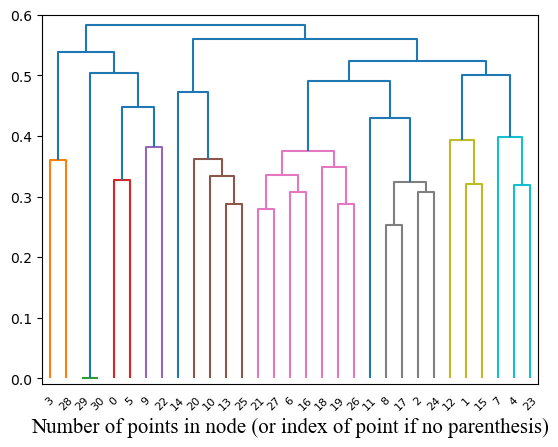

In [87]:
plot_dendrogram(clustering, truncate_mode="level", p=8)
plt.xlabel("Number of points in node (or index of point if no parenthesis)", **hfont)
plt.ylim((-0.01, 0.6))
plt.savefig("Clustering.png")
plt.show()